# Data and libraries

In [69]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve
import scipy.integrate as integrate

In [70]:
#Data

#Reactor
Pr=1500 #MW                             #Reactor power
iAs=180                                 #number of inner core assemblies
oAs=108                                 #number of outer core assembliess
p=10.7  #mm                             # pin pitch 
Npins=217                               #pins per assembly
Tcin=400 #°C                            #Inlet coolant temperature                        
Pincoolant=0.3 #Mpa                     #Inlet coolant temperature
mfr_ass=22 # (kg s-1)                   #Mass flow rate per assembly 
TargetB= 135 #GWd/t                     #Target Fuel burnup
fluxt=3.38*10**15 #cm^-1s^-1            #Total neutron flux
fluxf=0.7*fluxt #cm^-1s^-1              #Fast neutron flux


#Fuel pin
aL=1100 #mm                             #pin active length
lfeH=300 #mm                            #Lower fertile zone height
lfiH=250 #mm                            #Lower fissile zone height
ifeH=200 #mm                            #Inner fertile zone height
ufiH=350 #mm                            #Upper fissile zone height
fiRfi= 2.45/2 #mm                       #Fuel inner diameter (mm) – fissile pellets
feRfi=0                                 #Fuel inner diameter (mm) – fertile pellets
Rfo= 8.46/2 #mm                         #Fuel outer diameter
Rco=9.7/2 # (mm)                        #cladding outer radius
Wd=1 #mm                                #Wire spacer diameter
Pingas=0.1 #Mpa                           #Initial pin inner pressure
Tgas=20 #°C                             #Initial pin inner temperature
rhof=0.95 #%TD                          #Fuel density (percentage of theoretical density)
grainD= 10#micron                       #fuel grain diameter
Ppeak=46.3 # W/mm                       #axial peak power

#Axial peak factors
Pf=[0.001,0.005,0.01,0.03,0.205,0.38,0.45,0.51,0.55,0.57,0.58,0.315,0.05,0.04,0.04,0.05,0.06,0.08,0.46,0.84,0.89,0.94,0.98,1,0.98,0.92,0.86,0.81,0.77,0.71]
#Corrisponding height nodes
H=[0,130,230,290,300,310,350,400,450,490,540,550,560,590,630,670,700,740,750,760,770,790,830,880,930,980,1020,1050,1070,1100]

Throttling-adjusted flow rate

Throttling is the adjustement of the flow rate of a single assembly by opening and closing a valve at its inlet. By doing so, the heat exchenge can be enhanced or reduced.

For the scope of this work, it is sufficient to model this feature as a coefficient multiplying the standard mass flow rate.

In [71]:
throttling=1.9                         #throttling parameter
mfr=throttling*mfr_ass/(217)            #mass flow rate per pin adjusted by throttling

Pin-coolant Heat exchange geometrical parametrs

In [72]:
A=(p**2/4*math.sqrt(3)-math.pi*Rco**2/2)*10**-6 #m**2       #coolant channel section seen by a pin
Dh=4*A*1000/(math.pi*Rco) #m                                #Characteristic length of the pin (wet diameter)



# Interpolation

In this section, an interpolation of the axial peak factor is developed in order to calculate the temperature of the coolant along the pin active length.

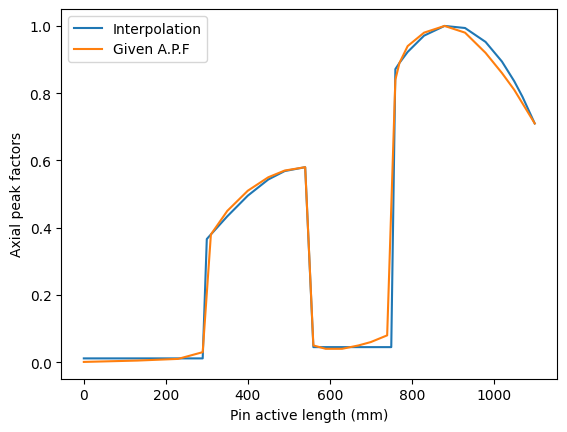

In [73]:
#values and parameters for the interpolations

#for f_1
val_f1=0                                       
for i in range(4):                             
    val_f1=val_f1+Pf[i]
########################

#for f_4 and f_3
val_f4=0                                      
for i in range(5):                            
    val_f4=val_f4+Pf[i+13]
###########################


#for f_3
m,q=sp.symbols('m q')                         
def f(x):                                      
    return m*x+q

x1=f(H[10])
x2=f(H[12])

sol_3=sp.solve( (sp.Eq(x1,Pf[10]), sp.Eq(x2,val_f4/6)), [m,q] )
###############################################################


#for f_5
C1,C2,C=sp.symbols('C1 C2 C')            
def f(x):
    return C+C1*x+C2*x**2
x1=f(H[20])
x2=f(H[23])
x3=f(H[29])
sol_5=sp.solve( (sp.Eq(x1,Pf[20]), sp.Eq(x2, Pf[23]), sp.Eq(x3,Pf[29])), [C1, C2, C])
####################################################################################

############################################################################################################################
###############   ACTUAL FUNCTIONS   ########################################################################################
#############################################################################################################################

def f1(x):                         #constant function interpolation of the axial peak factors (first fertile zone)
    return val_f1/4                #[0,300) 


#############################################################################################################################
def f2(x):                                     #sine function interpolation of the axial peak factors (first fissile zone)
                                               #[300,540)  
    return Pf[5]+(Pf[10]-Pf[5])*math.sin((x-H[5])*math.pi*0.5/(H[10]-H[5]))


#############################################################################################################################
def f3(x):                                   #linear interpolation of the axial peak factors (steep interface)
    return sol_3[m]*x +sol_3[q]                  #[540, 560)


#############################################################################################################################
def f4(x):                                    #constant function interpolation of the axial peak factors (second fertile zone)
    return val_f4/6                           #[560,700)


#############################################################################################################################


def f5(x):                                   #parabolic function interpolation of the axial peak factors (first fissile zone)
    return sol_5[C]+sol_5[C1]*x+sol_5[C2]*x**2     #[700,1100]


def PeakFactor(x):   #x is the disance from the bottom of the pin in mm, the function returns the value of the peak factor interpolated.
    if x<=H[3]:
        return(f1(x))
    elif x<=H[10]:
        return(f2(x))
    elif x<=H[12]:
        return f3(x)
    elif x<=H[18]:
        return(f4(x))
    else:
        return(f5(x))

Pfvals=[]
xvals=np.linspace(H[0],H[29],1101) #array of 1101, one for each active length mm
for i in range(len(H)):
    Pfvals.append(PeakFactor(H[i]))

plt.plot(H,Pfvals, label="Interpolation")
plt.plot(H,Pf, label="Given A.P.F")
plt.xlabel("Pin active length (mm)")
plt.ylabel("Axial peak factors")
plt.legend()

# Cold Geometry

With cold geometry, we refer to the temperature profile, axial and radial, of the pin and the coolant without taking into account the deferormations due to temperature. The "cold" geometry is hence the geometry of the pin at 20°C.

Symbols used in the following:
* $\Gamma$:  Mass flow rate
* $C_p$:  coolant specific heat
* z: axial coordinate null at the basis of the pin active length
* $ q'(z)= A.P.F.(z) \cdot q'_{max} $ : linear power

**Coolant Temperature Profile**


The temperature profile of the coolant along the axial cordinates will evolve following the equation:
\begin{equation}
    \Gamma C_p\frac{dT}{dz}(z)=q'(z)
\end{equation}

This equation was integrated to find the coolant profile, knowing the inlet coolant temperature.





In [74]:
##Temperature conversion °C --> °F

#Celsius to Fahrenheit
def C2F(T):
  return (T*(9/5) + 32)


In [75]:
########################################################################
########################## COOLANT PROPERTIES ##########################
########################################################################

#CSpecific heat J/(K kg)
def Cp(T):
    return 971.34 - 3.69*10**(-1)*T + (3.43*10**(-4))*T**2


#Density (Kg m^-3)
def Rho(T):
  Tf=C2F(T)
  return 954.1579 + Tf * (Tf * (Tf * 0.9667*10**(-9) - 0.46*10**(-5)) - 0.1273534)

#coolant speed (m/s)
def v_c(T):
  return mfr/(Rho(T)*A*2)

#Thermal conductivity (W m^-1 K^-1)
def K_c(T):
  Tf=C2F(T)
  return 94 - 3.25*10**(-2)*Tf + 3.62*10**(-6)*Tf**2

#Peclet number
def Pe(T):
  return Rho(T)*v_c(T)*Dh*Cp(T)/K_c(T)

#Nusselt number
def Nu(T):
  return 7 + 0.025*(Pe(T))**(0.8)

#Heat transfer coefficient (W m^-2 K^-1)
def h(T):
  return Nu(T)*K_c(T)/(Dh)

Text(0, 0.5, 'Coolant Temperature (°C)')

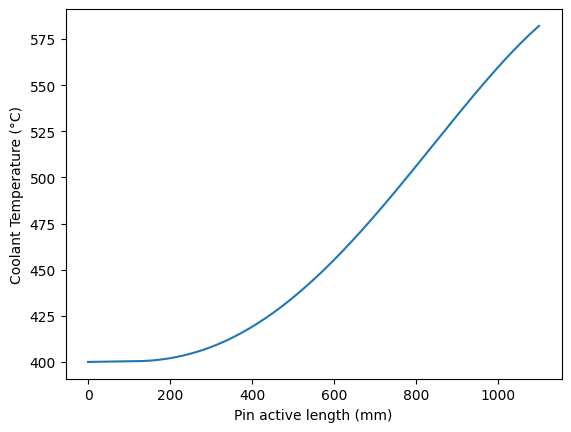

In [76]:
#Linear Power #W/mm
def Plin(z):
    return Ppeak*PeakFactor(z)

# T coolant
def dTdz(z, T):
    return (Plin(z)/(mfr*Cp(T)))


#This function solves the differential equation by separating the dominion in five pieces to better account
#for the great discontinuities in the axial peak factors.

def Tcoolantsolver(): 

    sol=integrate.solve_ivp(dTdz, (H[0],H[29]), [400], t_eval=xvals[H[0]:H[29]+1])
    
    #solve_ivp
    profile=np.zeros(len(sol.y.T))
    for i in range(len(sol.y.T)):
        profile[i]=(sol.y.T[i][0])
    return profile

Tcoolant=Tcoolantsolver()

plt.plot(xvals, Tcoolant)
plt.xlabel("Pin active length (mm)")
plt.ylabel("Coolant Temperature (°C)")

In [77]:
T=np.zeros(len(H)) #coolant temperature
Cp_v=np.zeros(len(H)) #coolant specific activity

for i in range(len(H)):           #here, only the values of temperature and specific activity in proximity of the nodes are selected
    T[i]=Tcoolant[int(H[i])]
    Cp_v[i]=Cp(T[i])

By means of the provided correlations, the properties and characteristic parameters of interest for the coolant are calculated and plotted.

From now on, there is no more need for 1101 points in the calculations, but the analysis will be done in proximity of the nodes provided along with the axial peak factors.

The values of the needed parametrs like thermal conductivity, specific heat etc. will be calculated with the values relative to that points only.

These values will be used first to find the outer temperature of the cladding, and then inward with the inner cladding temperature until reaching the inner fuel temperature.

In [78]:
Rho_v=np.zeros(len(H)) #coolant density
v_c_v=np.zeros(len(H)) #coolant speed
k_c_v=np.zeros(len(H)) #cladding thermal conductivity
h_v=np.zeros(len(H))   #heat transfer coefficient
for i in range(len(H)): #here, only the values of coolant properties in proximity of the nodes are selected
    Rho_v[i]=Rho(T[i])
    v_c_v[i]=v_c(T[i])
    k_c_v[i]=K_c(T[i])
    h_v[i]=h(T[i])

There is a constraint on the speed of the coolant (<10 m/s) due to the fact that high-speed molten lead may corrode the cladding iron but if throttling rises, so does the speed while the cladding maximum temperatures lowers and vicde versa.


Hence, the need for choosing the throttling factor as a covenient trade-off between corrosion and pin temperature arises.

A 1.9 throttling seemes the value that suits the best.

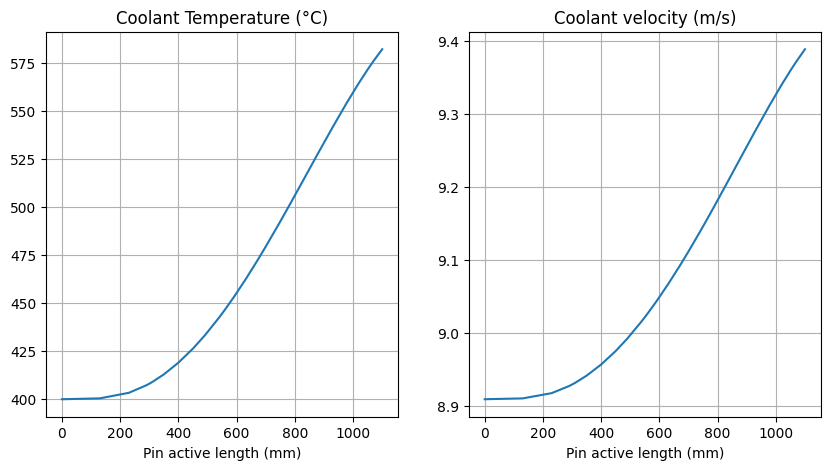

In [ ]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(H, T)
axs[0].set_title('Coolant Temperature (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, v_c_v)
axs[1].set_title('Coolant velocity (m/s)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()

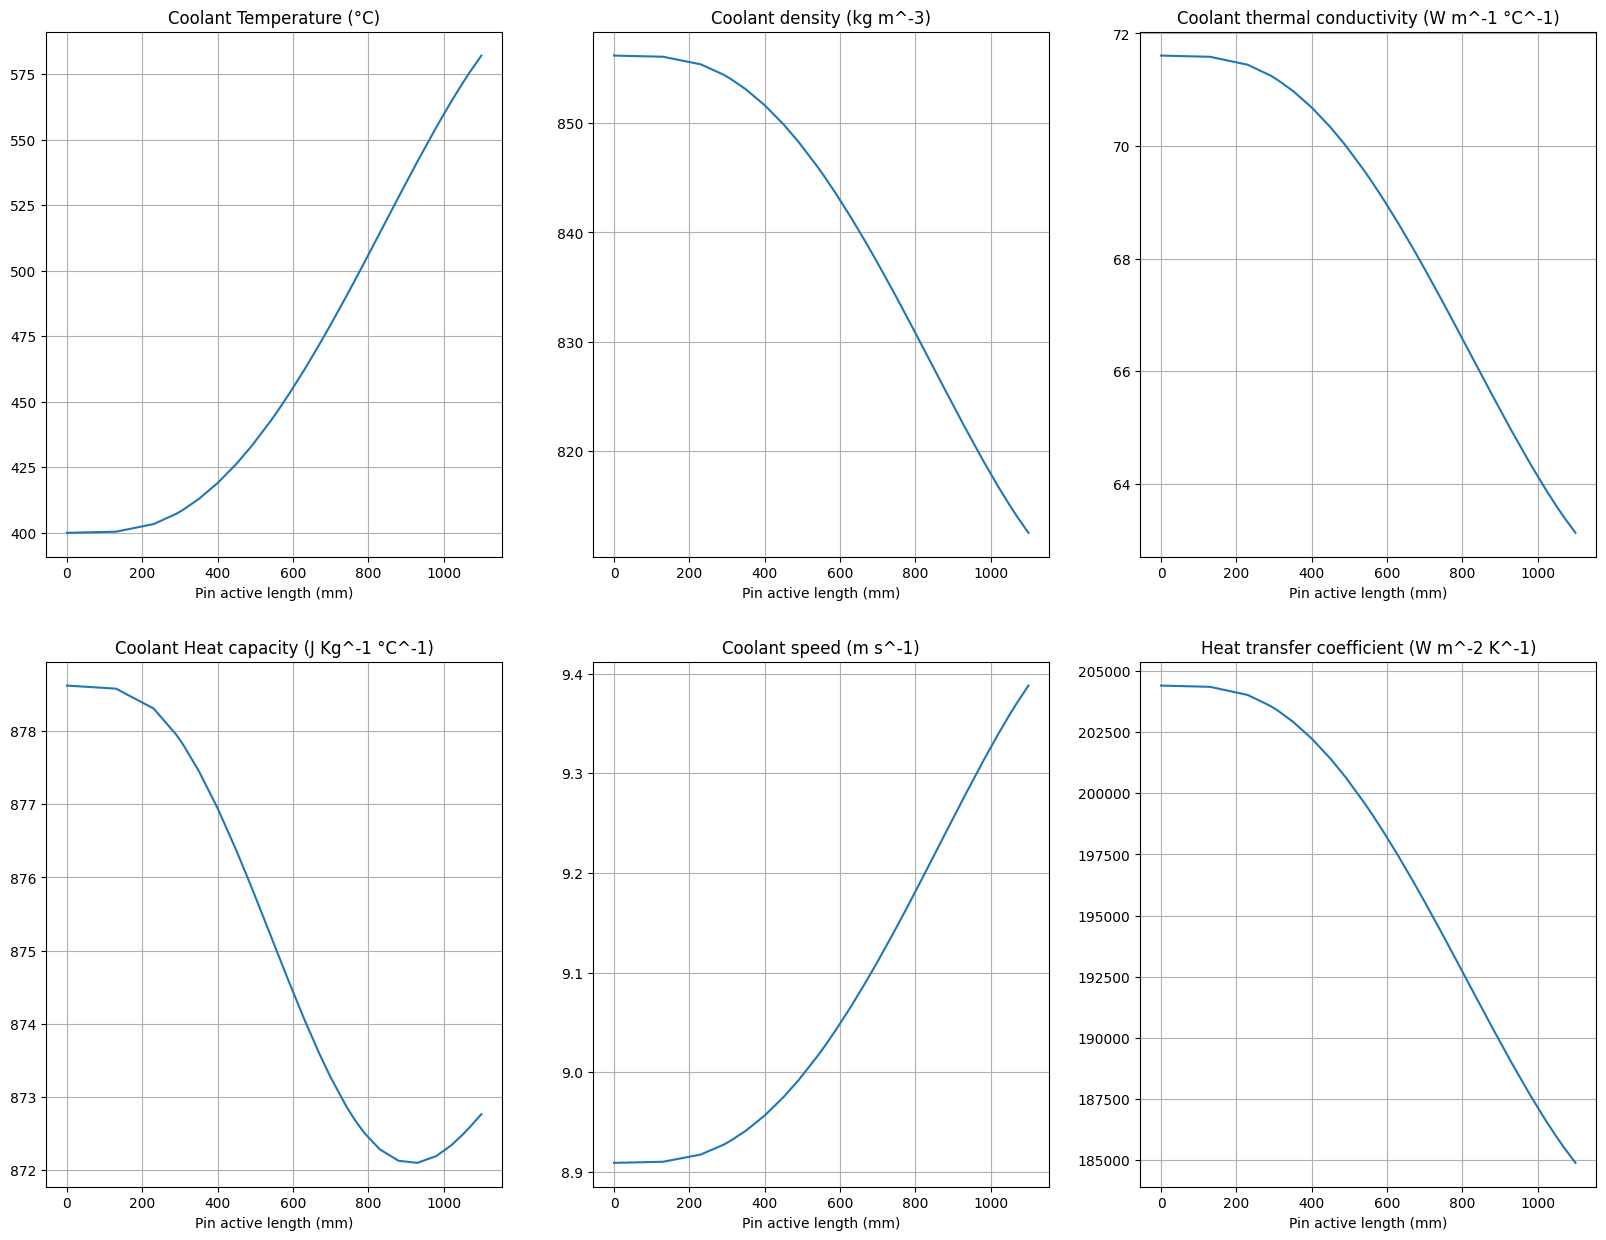

In [138]:
#plots                                                      #all coolant properties plotted
fig, axs = plt.subplots(2, 3, figsize=(20,15))

axs[0, 0].plot(H, T)
axs[0, 0].set_title('Coolant Temperature (°C)')
axs[0, 0].set_xlabel("Pin active length (mm)")
axs[0, 0].grid()
axs[1, 0].plot(H, Cp_v)
axs[1, 0].set_title('Coolant Heat capacity (J Kg^-1 °C^-1)')
axs[1, 0].set_xlabel("Pin active length (mm)")
axs[1, 0].grid()

axs[0, 1].plot(H, Rho_v)
axs[0, 1].set_title('Coolant density (kg m^-3)')
axs[0, 1].set_xlabel("Pin active length (mm)")
axs[0, 1].grid()
axs[1, 1].plot(H, v_c_v)
axs[1, 1].set_title('Coolant speed (m s^-1)')
axs[1, 1].set_xlabel("Pin active length (mm)")
axs[1, 1].grid()

axs[0, 2].plot(H, k_c_v)
axs[0, 2].set_title('Coolant thermal conductivity (W m^-1 °C^-1)')
axs[0, 2].set_xlabel("Pin active length (mm)")
axs[0, 2].grid()
axs[1, 2].plot(H, h_v)
axs[1, 2].set_title('Heat transfer coefficient (W m^-2 K^-1)')
axs[1, 2].set_xlabel("Pin active length (mm)")
axs[1, 2].grid()

**Cladding outern temperature profile**

The following assumptions are made in the calculations of $T_{c,o}(z)$:

$T_{c,o}(0)=400°C$: this is due to the heat trasnfer being only radial and subsequently at $z=0$ there hasn't been any heat transfer yet. If at $z=0$ there is no heat transfer, then the cladding and coolant have same temperature.\
So:
\begin{equation}
T_{c,o,i}=T_{i}+\frac{q'_{max}P_{f,i}}{h(T_{i})2R_{c,o}π}
\end{equation}

array([7.43311461e-03, 3.71748206e-02, 7.44708400e-02, 2.23903487e-01,
       1.53071166e+00, 2.83880119e+00, 3.36923620e+00, 3.83151012e+00,
       4.14898501e+00, 4.31604761e+00, 4.41496603e+00, 2.40048455e+00,
       3.81467345e-01, 3.06268430e-01, 3.07823226e-01, 3.86846345e-01,
       4.66162305e-01, 6.25140250e-01, 3.59983167e+00, 6.58331049e+00,
       6.98552644e+00, 7.40003245e+00, 7.76151675e+00, 7.97977048e+00,
       7.87823376e+00, 7.44864083e+00, 7.00030020e+00, 6.61823250e+00,
       6.30636387e+00, 5.83429194e+00])

Text(0.5, 1.0, 'Cladding outer Temperature (°C)')

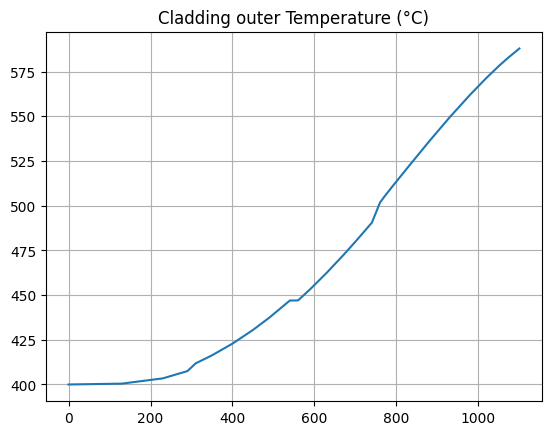

In [ ]:
#Cladding outern temperature
Tco=np.zeros(len(H))

for i in range(len(H)):
  Tco[i]=T[i]+(Ppeak*Pf[i]*1000/(h_v[i]*2*math.pi*(Rco/1000)))

plt.plot(H,Tco)
plt.grid()
plt.title('Cladding outer Temperature (°C)')

**Cladding thickness problem**

The most basic geometrical limit for the cladding thickness is given by the fixed outern radius for both cladding and fuel.

In [83]:
# Cladding possible thickness
k=0
count=100
tc=np.zeros(count)

while k<count:

  tc[k]=(Rco-Rfo)*k/count

  k=k+1

print("Since Rco and Rfo are given, the thickness is between 0 and "+str(Rco-Rfo)+" mm")

Since Rco and Rfo are given, the thickness is between 0 and 0.6199999999999992 mm


**Cladding inner temperature**\
For the calculation of the cladding inner temperature, we made the following assumptions:
1.  we chose a reasonable (in our opinion) cladding thickness: 0.25mm (after verifying that the maximum temperature ad midplane was not exceeding the design limits);
2.  while calculating the thermal conductivity of the steel $K=K(T)$, we chosed as T the arithmetic average between inner and outer cladding temperature;
3.  we repeated the same assumption for $z=0$, by assuming $T_{c,i}(z=0)=400°C$.\
\
\begin{equation}
T_{c,i,i}=T_{c,o,i}+\frac{q'_{max}P_{f,i}}{K(\frac{T_{c,i,i}+T_{c,o,i}}{2})2π}log(\frac{R_{c,o}}{R_{c,i}})
\end{equation}


In [84]:
# Inner cladding temperature (equazione risolta con fsolve)

k=0


Tci=np.zeros(len(H))

TciMAX=np.zeros(count)
halplane=np.zeros(count)
#kvals=[]
while k<count:
  for i in range(len(H)):
    q=Pf[i]*Ppeak

    def Tcisolver(Tx):
        return ((Tx - Tco[i])/q) - tc[k]/(2*math.pi*(13.95 + 0.01163*(Tx+Tco[i])/2)/1000)
    sol=fsolve(Tcisolver,400)
    Tci[i]=sol[0]
    TciMAX[k]=max(Tci)
    #halplane[k]=Tco[np.argmax(Tci)]+q*(0.5*tc[k])/(2*math.pi*(13.95 + 0.01163*(max(Tci)+Tco[i])/2))
    halplane[k]=0.5*(Tco[np.argmax(Tci)]+max(Tci))

  k=k+1

C:\Users\User\AppData\Local\Temp\ipykernel_20624\1418175376.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol=fsolve(Tcisolver,400)


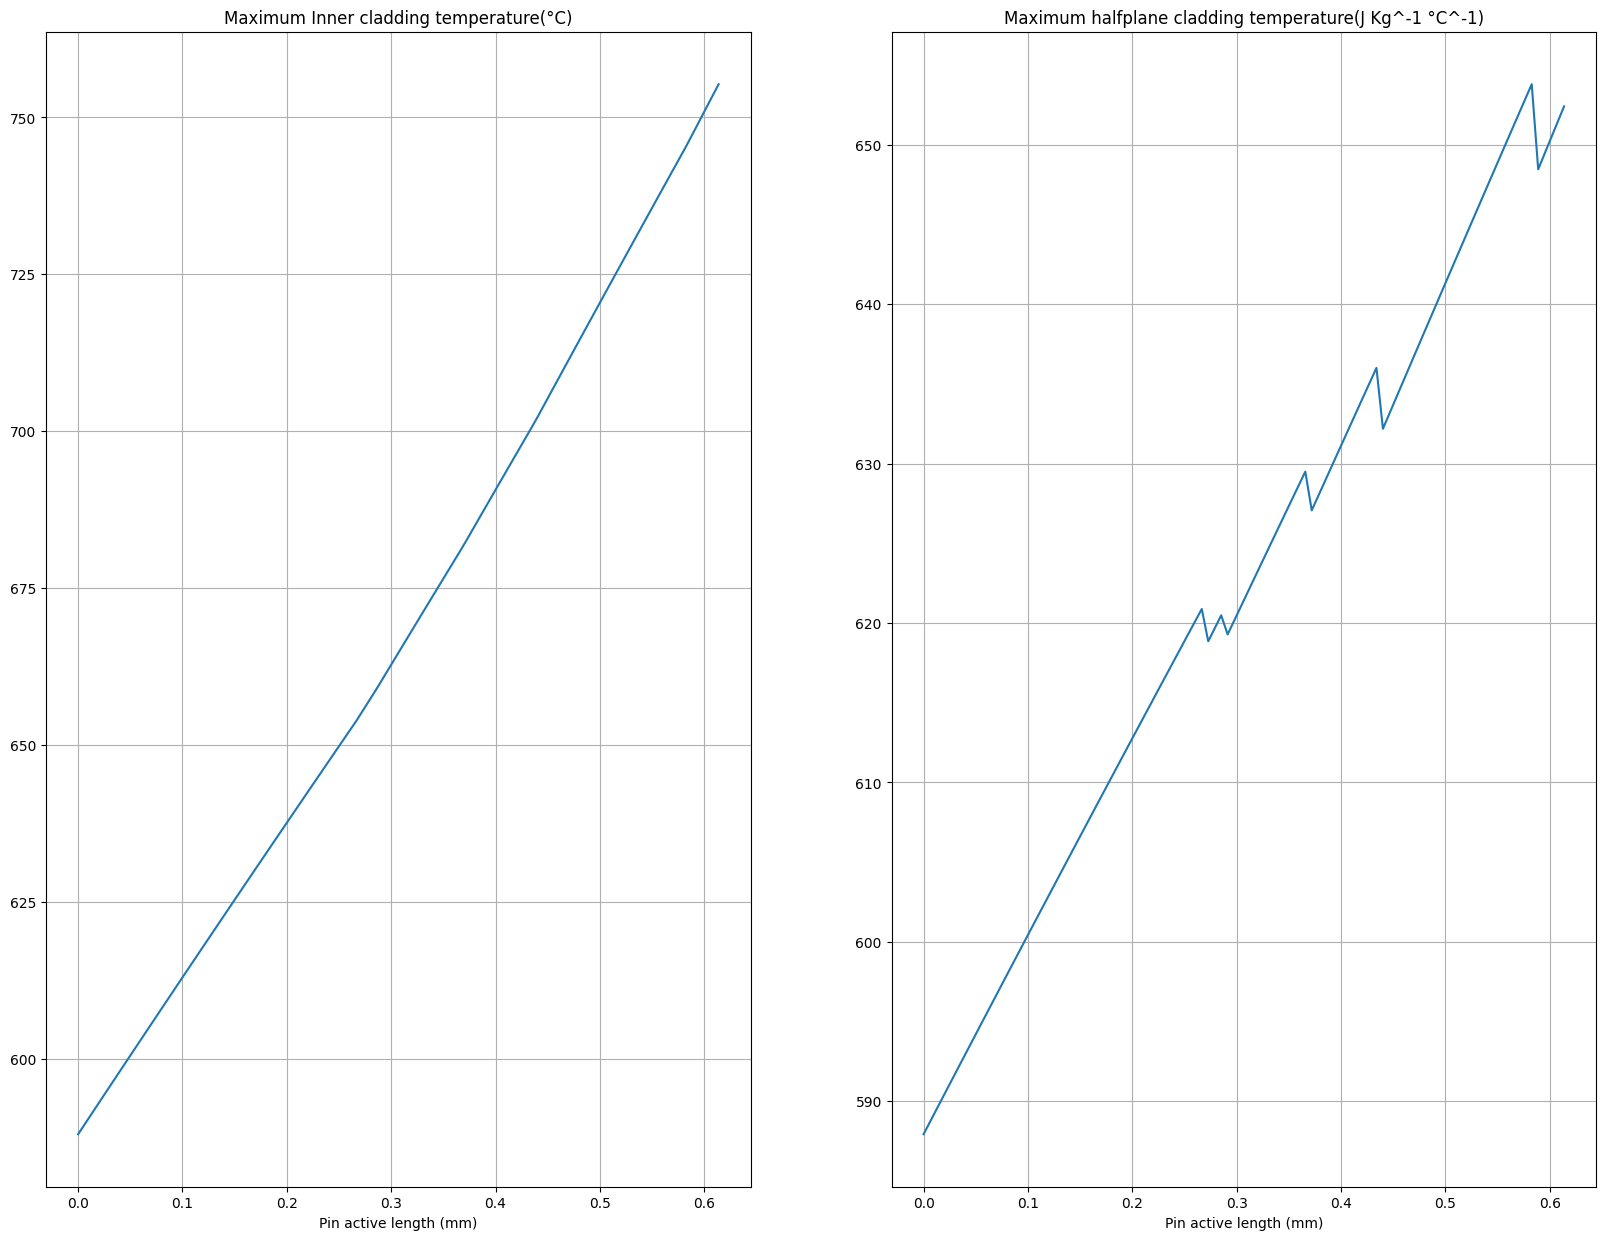

In [139]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(20,15))

axs[0].plot(tc, TciMAX)
axs[0].set_title('Maximum Inner cladding temperature(°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()

axs[1].plot(tc, halplane)
axs[1].set_title('Maximum halfplane cladding temperature(J Kg^-1 °C^-1)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()

array([400.05511226, 400.71902708, 403.89832824, 408.91202525,
       419.30430112, 429.68294303, 437.40770059, 446.66321311,
       456.04710165, 463.76034458, 473.61978765, 461.50499197,
       449.33881969, 455.23417622, 464.34842572, 474.54427002,
       482.63363336, 494.11189443, 516.7054363 , 539.04932705,
       544.2672798 , 552.15656726, 564.94794754, 579.44038383,
       591.7179684 , 601.52170848, 608.22884351, 612.58533089,
       614.91158337, 617.97507609])

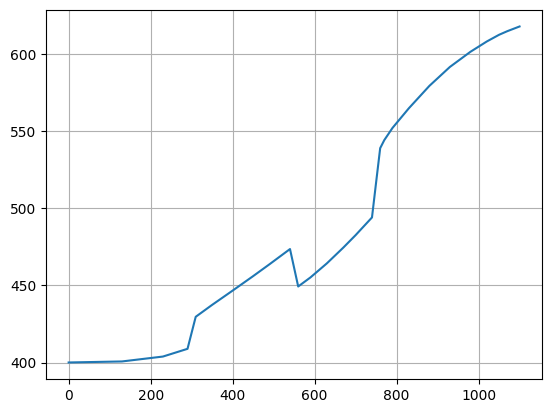

In [ ]:
#Cladding inner temperature

TC=0.55 # chosen cladding thickness mm
Rci=Rco-TC
Tci=np.zeros(len(H))


for i in range(len(H)):
  x=sp.symbols('x')
  Kcla=13.95+0.01163*(x+Tco[i])/2 #W/m K
  equazione=sp.Eq(x,Tco[i]+(Ppeak*Pf[i]*(math.log(Rco/(Rco-TC)))/(0.001*Kcla*2*math.pi)))
  x=sp.solve(equazione)
  Tci[i]=x[1]


plt.plot(H, Tci)
plt.grid()

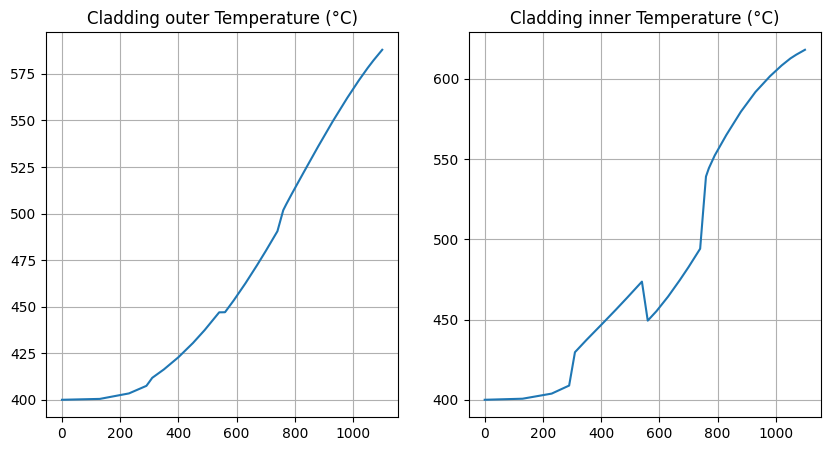

In [87]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(H, Tco)
axs[0].set_title('Cladding outer Temperature (°C)')
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('Cladding inner Temperature (°C)')
axs[1].grid()

**Fuel Outer temperature**\
In the evaluation of the temperature variation across the gap, the following assumptions are made:
1. only the term due to the conduction heat transfer is considered (at least for now). This is due to the fact that in cold geometry there is no contribution of contact pressure (there is no swelling/expansion) and the radiative contribution is order of magnitudes lower than the conduction term;
2. The $t_{eff}$ of the gap is calculated as:
\begin{equation}
t_{eff}=R_{c,i}-R_{f,o}+t_{jump}\\
t_{jump}(He)≃10μm
\end{equation}
3.  We assumed $r_{gap}$ to be $r_{c,i}$ because it's the most conservtive estimate;
4.  Since $K=K(T)$, we used $T=\frac{T_{f,o}+T_{c,i}}{2}$ as a reference for K computation.

So:
\begin{equation}
T_{f,o}=T_{c,i}+q'(z)R_{gap}=T_{c,i}+\frac{q'(z)}{h(T)2πr_{gap}}=T_{c,i}+\frac{q'(z)t_{eff}}{K(\frac{T_{f,o}+T_{c,i}}{2})2πr_{gap}}
\end{equation}

array([400.4977255 , 402.92808491, 408.29447333, 421.95895011,
       503.99841349, 579.76825731, 611.64570063, 640.48567624,
       661.99974681, 675.11532231, 686.55898241, 583.70426625,
       470.03960173, 471.72742504, 480.68359268, 494.70503311,
       506.5777416 , 525.54599521, 682.59132569, 821.54311774,
       840.59999943, 861.49973165, 883.05831838, 900.05073059,
       903.94825949, 894.5858247 , 882.7271907 , 871.78648994,
       862.02751572, 846.9131469 ])

Text(0.5, 1.0, 'Fuel outern temperature (°C)')

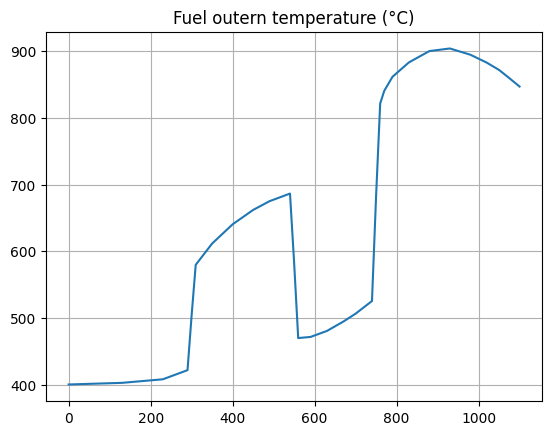

In [88]:
#Fuel outer temperature

i=0

Tfo=np.zeros(len(H))

for i in range(len(H)):

    q=Pf[i]*Ppeak

    def Tfosolver(Tx):
        return ((Tx - Tci[i])/q) - (Rco-TC-Rfo)/(2*math.pi*Rci*(15.8*(10**(-4))*((273.15 + ((Tx + Tci[i])/2))**(0.79)))*0.001)

    sol=fsolve(Tfosolver,1000)
    Tfo[i]=sol[0]
    i=i+1

display(Tfo)
plt.plot(H,Tfo)
plt.grid()
plt.title('Fuel outern temperature (°C)')

Since the burnup in FIMA is calculated as ratio between the number of fissions and initial fissile atoms, it is reasonable to find a so high value for the FIMA in natural uranium oxide if we use the same Target Burnup value for both kinds of pellet.\
The calculation greatly overestimates the FIMA for the natural uranium pellets and underestimates it for MOX pellets.\
The number of fissions needs to be adjusted for every pellet by taking into account the axial peak factor.

**Inner Fuel temperature**\
In the evaluation of the temperature variation across the fuel, the following assumptions and reasonings were made:
1.  for the porosity:
\begin{equation}
p=1-\frac{\rho_{real}}{\rho_{theoretical}}
\end{equation}
which is equivalent to stating that the deviation from the TD is due to the voids in the fuel material;
2.  for the burnup, $Bu=0$ because we are in cold geometry, we assume the fuel is fresh;
3.  for the themal resistance, up to 300mm and between 600mm and 800mm we deal with nat-u oxide pellets, otherwise it's MOX.

So:
\begin{equation}
T_{f,i}^{MOX}(z)=T_{f,o}+q'(z)R_{MOX}\\
T_{f,i}^{UO_2}(z)=T_{f,o}+q'(z)R_{UO_2}\\
\end{equation}
And since the two kind of pellets have a different geometry:
\begin{equation}
R_{MOX}=\frac{1-log((\frac{r_{f,o}}{r_{f,i}})^2)}{(\frac{r_{f,o}}{r_{f,i}})^2-1}\frac{1}{4πK_{MOX}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)}\\
R_{UO_2}=\frac{1}{4πK_{UO_2}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)}
\end{equation}

C:\Users\User\AppData\Local\Temp\ipykernel_20624\2685386623.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return ((Tx - Tfo[i])/(Potenza*10**3)) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo[i])/2)*5.8*10**(-4)) ) ) )


array([ 401.28268469,  406.87079784,  416.24575033,  446.39936349,
        701.58865868, 1185.1702021 , 1345.74256068, 1485.59174451,
       1580.70297455, 1630.40816645, 1660.38928874, 1077.9810787 ,
        538.61323023,  526.43916434,  515.5451744 ,  539.11463091,
        560.75852082,  599.83540246, 1271.5077293 , 2196.73432284,
       2326.77721011, 2456.15653125, 2457.69872862, 2495.46437154,
       2471.58880055, 2383.96301793, 2290.81305199, 2209.33868616,
       2141.29190033, 2035.34928315])

Text(0.5, 1.0, 'Fuel Inner temperature (°C)')

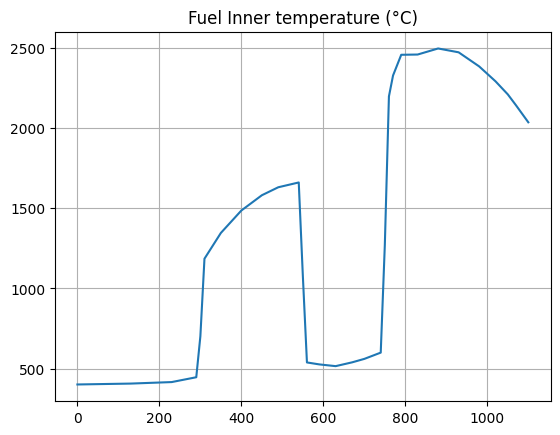

In [89]:
#Fuel inner temperature

Rfi=2.45/2 # mm

dev=0.05
BUFIMA=0 #cold geometry
por=0.05

Tfi=np.zeros(len(H))

for i in range(len(H)):
    Potenza=Ppeak*Pf[i]
    if H[i]<=300 or (H[i]>=600 and H[i]<=800):
        def Tfisolver(Tx):
            return ((Tx - Tfo[i])/(Potenza*10**3)) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo[i])/2)*5.8*10**(-4)) ) ) )
        sol=fsolve(Tfisolver,1000)
        Tfi[i]=sol[0]
    else:
        def Tfisolver(Tx):
            return ((Tx - Tfo[i])/(Potenza*10**3)) - (1-(math.log((Rfo/Rfi)**2))/((Rfo/Rfi)**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfo[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfo[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))

        sol=fsolve(Tfisolver,1000)
        Tfi[i]=sol[0]


display(Tfi)

plt.plot(H, Tfi)
plt.grid()
plt.title('Fuel Inner temperature (°C)')

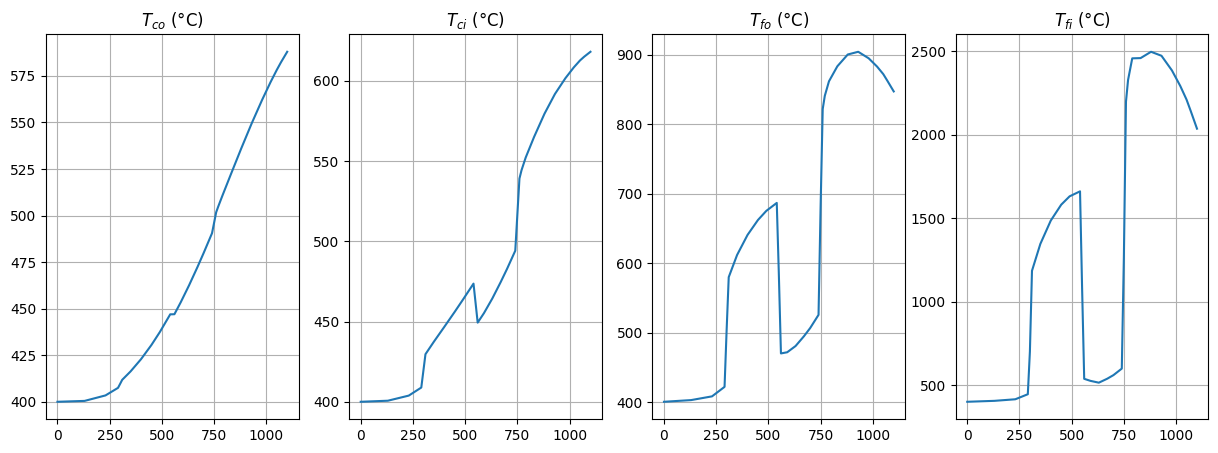

In [90]:
#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].grid()
axs[2].plot(H, Tfo)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].grid()
axs[3].plot(H, Tfi)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].grid()

# Hot geometry

The aim of this section is simple: we use the temperatures found in the previous section to compute the thermal expansion of the materials.\
Under these new circumstances, we repeat the previously done calculation.

In [91]:
#epsilon cladding
epsilon=-3.101*10**-4+1.545*10**-5*((Tci+Tco)/2)+2.75*10**-9*((Tci+Tco)/2)**2
display(epsilon)

array([0.00631045, 0.00632049, 0.00637454, 0.00645482, 0.00656571,
       0.00667714, 0.00678591, 0.0069268 , 0.00707895, 0.00720982,
       0.0073841 , 0.00727536, 0.00716669, 0.00727662, 0.00744053,
       0.00762031, 0.00776252, 0.00796258, 0.00821941, 0.0084753 ,
       0.00855147, 0.00867749, 0.00889946, 0.00916244, 0.00940115,
       0.00961008, 0.00976085, 0.00986328, 0.00992332, 0.01000532])

The following equation will be applied for both internal and external radii, and for both cladding and fuel:
\begin{equation}
r=r_0[1+ϵ_{th}(T)]=r_0[1+α(T)(T-T_{ref})]
\end{equation}
The temperature for the cladding, the filling gas and the fuel will be the average between internal and external.

In [92]:
#cladding expansion
Rco2=Rco*(1+epsilon)
display(Rco2)

Rci=Rco-TC
Rci2=Rci*(1+epsilon)
display(Rci2)

TC2=Rco2-Rci2
display(TC2)

array([4.88060569, 4.88065437, 4.88091654, 4.88130589, 4.88184369,
       4.88238412, 4.88291165, 4.88359497, 4.88433292, 4.88496762,
       4.88581289, 4.88528548, 4.88475845, 4.88529159, 4.88608655,
       4.8869585 , 4.88764823, 4.88861852, 4.88986416, 4.8911052 ,
       4.89147463, 4.89208581, 4.89316237, 4.89443785, 4.89559557,
       4.89660887, 4.89734011, 4.89783689, 4.8981281 , 4.89852581])

array([4.32713494, 4.3271781 , 4.32741054, 4.32775574, 4.32823255,
       4.3287117 , 4.3291794 , 4.32978523, 4.3304395 , 4.33100222,
       4.33175164, 4.33128403, 4.33081677, 4.33128945, 4.33199426,
       4.33276733, 4.33337885, 4.3342391 , 4.33534348, 4.33644378,
       4.33677132, 4.33731319, 4.33826766, 4.33939851, 4.34042494,
       4.34132333, 4.34197165, 4.34241209, 4.34267028, 4.34302288])

array([0.55347075, 0.55347627, 0.553506  , 0.55355015, 0.55361114,
       0.55367243, 0.55373225, 0.55380974, 0.55389342, 0.5539654 ,
       0.55406126, 0.55400145, 0.55394168, 0.55400214, 0.55409229,
       0.55419117, 0.55426939, 0.55437942, 0.55452068, 0.55466141,
       0.55470331, 0.55477262, 0.5548947 , 0.55503934, 0.55517063,
       0.55528554, 0.55536847, 0.5554248 , 0.55545783, 0.55550293])

In [93]:
diff=Rco2-Rco
display(diff)

array([0.03060569, 0.03065437, 0.03091654, 0.03130589, 0.03184369,
       0.03238412, 0.03291165, 0.03359497, 0.03433292, 0.03496762,
       0.03581289, 0.03528548, 0.03475845, 0.03529159, 0.03608655,
       0.0369585 , 0.03764823, 0.03861852, 0.03986416, 0.0411052 ,
       0.04147463, 0.04208581, 0.04316237, 0.04443785, 0.04559557,
       0.04660887, 0.04734011, 0.04783689, 0.0481281 , 0.04852581])

In the next calculation we assume that the chenge in the cladding outer radius (which is in the order of 30μm) doesn't change the coolant properties.\
The only impact of this expansion is the change of the heat transfer geometry in the cladding.

array([400.0073865 , 400.48048258, 403.42214444, 407.48748315,
       409.60747906, 411.77760956, 416.28327439, 422.83727984,
       430.48479797, 437.38502128, 446.93758569, 446.96105537,
       447.02181539, 453.38739461, 462.51169864, 472.26194812,
       479.90757124, 490.50067409, 496.11153527, 501.74707334,
       504.83919747, 510.67725321, 522.00020643, 535.96794358,
       549.42175359, 562.06273204, 571.50803387, 578.10384479,
       582.19069073, 587.87625661])

array([-4.66121688e-05, -2.33487281e-04, -4.71710719e-04, -1.43598838e-03,
       -9.98465196e-03, -1.88293424e-02, -2.27092202e-02, -2.63575227e-02,
       -2.91640179e-02, -3.08951700e-02, -3.23615979e-02, -1.73382398e-02,
       -2.71440514e-03, -2.21249849e-03, -2.27345084e-03, -2.92559449e-03,
       -3.59072215e-03, -4.93840802e-03, -2.93472927e-02, -5.53266091e-02,
       -5.92300147e-02, -6.36612649e-02, -6.84639914e-02, -7.24503733e-02,
       -7.33746413e-02, -7.09006509e-02, -6.76683657e-02, -6.46398913e-02,
       -6.19651682e-02, -5.77957054e-02])

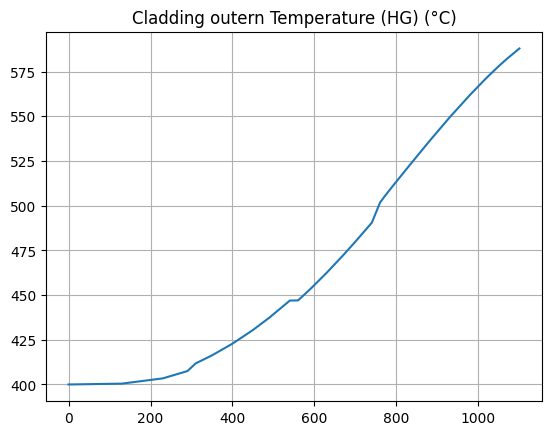

In [94]:
#Cladding outern temperature (HG)
Tco2=np.zeros(len(H))
#Tco[i]=T[i]+(Ppeak*Pf[i]*1000/(h_v[i]*2*math.pi*(Rco/1000)))

for i in range(len(H)):
  Tco2[i]=T[i]+(Ppeak*Pf[i]*1000/(h_v[i]*2*math.pi*(Rco2[i]/1000)))



display(Tco2)
plt.plot(H,Tco2)
plt.grid()
plt.title('Cladding outern Temperature (HG) (°C)')

diff=Tco2-Tco
display(diff)

The result for the cladding outer surface is a very slight temperature decrease.

array([400.05506565, 400.71879359, 403.89785653, 408.91058926,
       419.29431647, 429.66411369, 437.38499137, 446.63685559,
       456.01793763, 463.72944941, 473.58742606, 461.48765373,
       449.33610528, 455.23196372, 464.34615227, 474.54134442,
       482.63004264, 494.10695602, 516.67608901, 538.99400044,
       544.20804979, 552.09290599, 564.87948355, 579.36793346,
       591.64459376, 601.45080783, 608.16117515, 612.520691  ,
       614.8496182 , 617.91728039])

array([-4.66121679e-05, -2.33487281e-04, -4.71710720e-04, -1.43598838e-03,
       -9.98465196e-03, -1.88293424e-02, -2.27092202e-02, -2.63575227e-02,
       -2.91640179e-02, -3.08951700e-02, -3.23615979e-02, -1.73382398e-02,
       -2.71440514e-03, -2.21249849e-03, -2.27345084e-03, -2.92559449e-03,
       -3.59072215e-03, -4.93840802e-03, -2.93472927e-02, -5.53266091e-02,
       -5.92300147e-02, -6.36612649e-02, -6.84639914e-02, -7.24503733e-02,
       -7.33746413e-02, -7.09006509e-02, -6.76683657e-02, -6.46398913e-02,
       -6.19651682e-02, -5.77957054e-02])

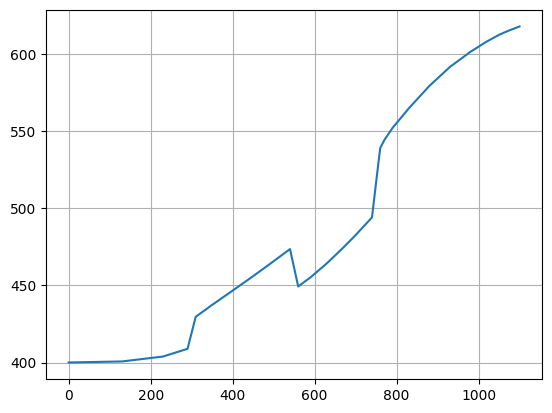

In [95]:
#Cladding inner temperature (HG)

Tci2=np.zeros(len(H))


for i in range(len(H)):
  x=sp.symbols('x')
  Kcla=13.95+0.01163*(Tci[i]+Tco[i])/2 #W/m K
  equazione=sp.Eq(x,Tco2[i]+(Ppeak*Pf[i]*1000*(math.log(Rco2[i]/(Rci2[i])))/(Kcla*2*math.pi)))
  x=sp.solve(equazione)
  Tci2[i]=x[0]

display(Tci2)
plt.plot(H, Tci2)
plt.grid()

diff=Tci2-Tci
display(diff)

The same result found for the outer surface was found for the inner one: a very slight temperature decrease.

In [96]:
#fuel expansion
alpha=1.2*10**-5 #°C**-1

Rfo2=Rfo*(1+alpha*(-25+(Tfi+Tfo)/2))
Rfi2=fiRfi*(1+alpha*(-25+(Tfi+Tfo)/2))

After computing the expansion of the radii of the cladding and the fuel, it is important to check whether the expansion led to a contact between fuel and cladding. In that case we would need to change the heat exchange coefficient between cladding and fuel.

In [97]:
diff=Rci2-Rfo2
display(diff)
flag=0
for i in range(len(diff)):
  if diff[i]<=0:
    flag=1
    break

if flag==0:
  print('There is no contact between fuel and cladding: we can use the same assumptions as before.')
else:
  print('There is contact between fuel and cladding')


array([0.07805476, 0.07789441, 0.07775271, 0.07698581, 0.06890375,
       0.05518656, 0.05076989, 0.04709439, 0.0447887 , 0.04375703,
       0.04345509, 0.06037946, 0.07648616, 0.07722498, 0.07797897,
       0.07779798, 0.07755885, 0.07694592, 0.05701745, 0.0311089 ,
       0.02765229, 0.02438008, 0.02474825, 0.02448933, 0.02602281,
       0.02938276, 0.0326962 , 0.03548213, 0.03771503, 0.04114006])

There is no contact between fuel and cladding: we can use the same assumptions as before.


array([400.60834849, 403.47514106, 409.37400062, 425.01942778,
       514.13850001, 568.50200115, 587.62864142, 603.63755014,
       616.08310115, 624.87925031, 635.005273  , 583.46194679,
       474.73027263, 475.63525915, 484.72525263, 499.63688482,
       512.34960957, 532.84233518, 674.19918911, 703.49989329,
       702.25090092, 702.71788868, 721.39768446, 735.89996306,
       750.82542682, 764.76242975, 773.97179419, 779.29037478,
       781.63942697, 783.51623388])

array([ 1.10622985e-01,  5.47056155e-01,  1.07952729e+00,  3.06047766e+00,
        1.01400865e+01, -1.12662562e+01, -2.40170592e+01, -3.68481261e+01,
       -4.59166457e+01, -5.02360720e+01, -5.15537094e+01, -2.42319454e-01,
        4.69067089e+00,  3.90783410e+00,  4.04165995e+00,  4.93185170e+00,
        5.77186797e+00,  7.29633998e+00, -8.39213657e+00, -1.18043224e+02,
       -1.38349099e+02, -1.58781843e+02, -1.61660634e+02, -1.64150768e+02,
       -1.53122833e+02, -1.29823395e+02, -1.08755397e+02, -9.24961152e+01,
       -8.03880888e+01, -6.33969130e+01])

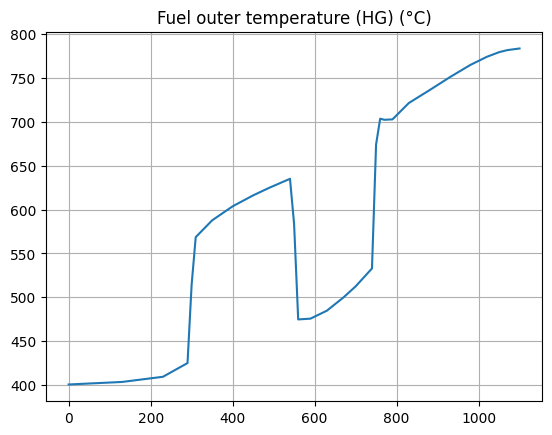

In [98]:
#Fuel outer temperature

Tfo2=np.zeros(len(H))

for i in range(len(H)):

    q=Pf[i]*Ppeak

    def Tfosolver(Tx):
        return ((Tx - Tci2[i])/(q*1000)) - (Rco2[i]-TC2[i]-Rfo2[i]+0.01)/(2*math.pi*Rci2[i]*(15.8*(10**(-4))*((273.15 + ((Tfo[i] + Tci[i])/2))**(0.79))))

    sol=fsolve(Tfosolver,1000)
    Tfo2[i]=sol[0]


display(Tfo2)


plt.plot(H,Tfo2)
plt.grid()
plt.title('Fuel outer temperature (HG) (°C)')
diff=Tfo2-Tfo
display(diff)

In this case the temperature decrease is way more important, even hundreds of degrees.

In [99]:
#Fuel inner temperature

dev=0.05
BUFIMA=0
por=0.05

Tfi2=np.zeros(len(H))

for i in range(len(H)):
    Potenza=Ppeak*Pf[i]*1000
    if H[i]<=300 or (H[i]>=600 and H[i]<=800):
        def Tfisolver(Tx):
            return ((Tx - Tfo2[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tfi[i]+Tfo[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tfi[i]+Tfo[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tfi[i]+Tfo[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tfi[i]+Tfo[i])/2)*5.8*10**(-4)) ) ) )
        sol=fsolve(Tfisolver,1000)
        Tfi2[i]=sol[0]

    else:
        def Tfisolver(Tx):
            return ((Tx - Tfo2[i])/Potenza) - (1-(math.log((Rfo2[i]/Rfi2[i])**2))/((Rfo2[i]/Rfi2[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tfi[i]+Tfo[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tfi[i]+Tfo[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))

        sol=fsolve(Tfisolver,1000)
        Tfi2[i]=sol[0]



display(Tfi2)


array([ 401.39330767,  407.41785399,  417.32527763,  449.45984115,
        711.72874519, 1173.90394594, 1321.72550148, 1448.74361842,
       1534.78632889, 1580.17209446, 1608.83557933, 1077.73875925,
        543.30390112,  530.34699845,  519.58683435,  544.04648262,
        566.53038879,  607.13174244, 1263.11559272, 2078.69109839,
       2188.4281116 , 2297.37468829, 2296.0380947 , 2331.31360401,
       2318.46596788, 2254.13962298, 2182.05765547, 2116.84257099,
       2060.90381157, 1971.95237013])

In [100]:
print(Tco[23])

536.0403939571996


# Hot geometry iteration

In [101]:
Tfinew=Tfi2
Tfiold=Tfi
Tcinew=Tci2
Tciold=Tci

Tfonew=Tfo2
Tfoold=Tfo
Tconew=Tco2
Tcoold=Tco
print(abs(max(Tfinew) - max(Tfiold)))
while abs(max(Tfinew) - max(Tfiold)) > 1:
    i=0

    while i<30:
        Tfiold[i]=Tfinew[i]
        Tcoold[i]=Tconew[i]
        Tciold[i]=Tcinew[i]
        Tfoold[i]=Tfonew[i]
        i=i+1

    epsilon=-3.101*10**-4+1.545*10**-5*((Tciold+Tcoold)/2)+2.75*10**-9*((Tciold+Tcoold)/2)**2

    Rconew=Rco*(1+epsilon)

    Rci=Rco-TC
    Rcinew=Rci*(1+epsilon)

    TCnew=Rconew-Rcinew

    diff=Rco2-Rco

    Tconew=np.zeros(len(H))

    for i in range(len(H)):
      Tconew[i]=T[i]+(Ppeak*Pf[i]*1000/(h_v[i]*2*math.pi*(Rconew[i]/1000)))

    diff=Tconew-Tco

    alpha=1.2*10**-5 #°C**-1

    Rfonew=Rfo*(1+alpha*(-25+(Tfiold+Tfoold)/2))
    Rfinew=fiRfi*(1+alpha*(-25+(Tfiold+Tfoold)/2))

    diff=Rcinew-Rfonew
    flag=0
    for i in range(len(diff)):
      if diff[i]<=0:
        flag=1
        print("Contact fuel cladding: end of cycle")
        break


    Tfonew=np.zeros(len(H))

    for i in range(len(H)):

        q=Pf[i]*Ppeak*1000

        def Tfosolver(Tx):
            return ((Tx - Tcinew[i])/q) - (Rconew[i]-TCnew[i]-Rfonew[i])/(2*math.pi*Rcinew[i]*(15.8*(10**(-4))*((273.15 + ((Tfoold[i] + Tciold[i])/2))**(0.79))))

        sol=fsolve(Tfosolver,1000)
        Tfonew[i]=sol[0]


    dev=0.05
    BUFIMA=0
    por=0.05

    Tfinew=np.zeros(len(H))

    for i in range(len(H)):
        Potenza=Ppeak*Pf[i]*1000

        if H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfonew[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tfiold[i]+Tfoold[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tfiold[i]+Tfoold[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tfiold[i]+Tfoold[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tfiold[i]+Tfoold[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfinew[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfonew[i])/Potenza) - (1-(math.log((Rfonew[i]/Rfi2[i])**2))/((Rfonew[i]/Rfinew[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tfiold[i]+Tfoold[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tfiold[i]+Tfoold[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))

            sol=fsolve(Tfisolver,1000)
            Tfinew[i]=sol[0]



164.15076753000858


In [102]:
print(Tco[23])

535.9679540952594


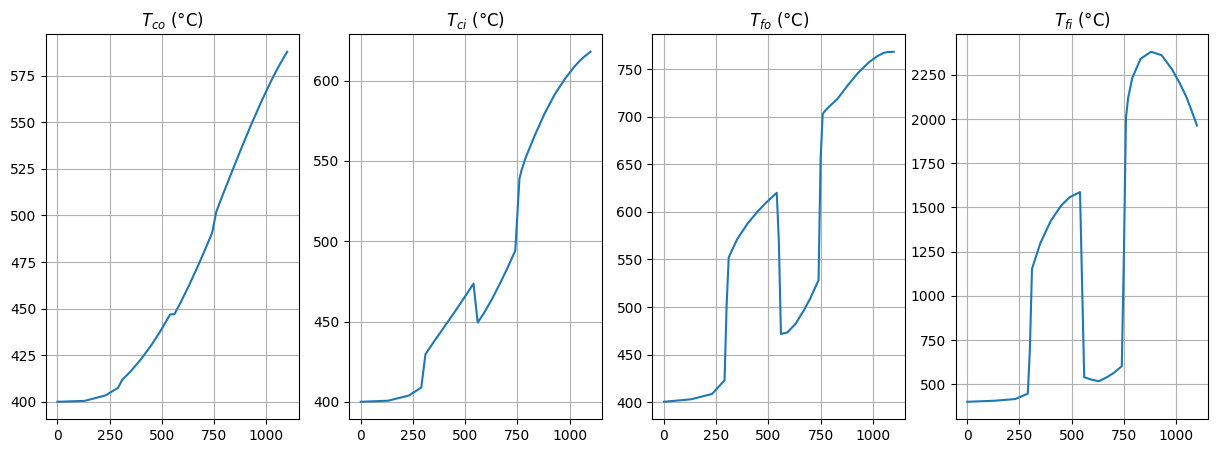

In [103]:
#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tconew)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].grid()
axs[1].plot(H, Tcinew)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].grid()
axs[2].plot(H, Tfonew)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].grid()
axs[3].plot(H, Tfinew)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].grid()

In [104]:
print(max(Tfinew))

2380.1820831166046


# Restructuring

**Fuel restructuring**

Goal:

Evaluate radius of central void (Rvoid=Rfi_res),radius of columnar region (Rcol) and effect on fuel temperature (Tfi_res).

Assumption:

1. Considerate a two zones model by simplifying the initial model (three zones) avoiding the equiaxed grains region, because the effect of porosity happen just between the central void and the columnar grain region.

2. Generation of heat it's uniform inside the fuel pin.

3. Final porosity is null inside the restructured zone.


To find Rcol, we solved this equation using the solver:

\begin{equation}
\ 1600-T_{f,o}[i+1]=(1-(\frac{R_x}{R_{f,o}[i+1]})^2)(\frac{q}{4\pi k})
\end{equation}

To find Tfi_res, we solved this equation using the solver:

\begin{equation}
\ \frac{(T_{x}-1600)(R_{f,o}[i+1])^2}{q(R_{col}[i+1]^2-R_{f,i}[i+1]^2)} = (1-log{\frac{R_{col}[i+1]}{R_{f,i}[i+1]}})(\frac{2(R_{f,i}[i+1])^2}{(R_{col}[i+1])^2-(R_{f,i}[i+1])^2} \frac{1}{4\pi k})
\end{equation}

The only thing changing between fertile and fissile region is the thermal conductivity k (\lambda in the table given), considering T in k equal to:

\begin{equation}
\ T=\frac{1600+T_{f,o}[i+1]}{2}
\end{equation}

Colloidal Radius:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         2.12740824 2.31742247 2.48076344 3.29474603 3.33831112
 3.33330197 3.27407829 3.19865171 3.12226192 3.04941264 2.91815661]


New Void/Inner Fuel Radius:
[0.         0.         0.         0.         0.         1.23716124
 1.2383702  1.23942206 1.24015627 1.24056305 1.24085382 1.23660209
 1.23207165 1.23199191 0.         0.         0.         0.
 0.         0.47570294 0.51819142 0.55471557 1.42137682 1.42678306
 1.42616001 1.41885917 1.40974533 1.40071582 1.39228659 1.37754298]


New Tfi:
[ 401.33048744  407.10459456  416.70257871  447.61912622  699.56295682
 1152.40769771 1297.94236307 1424.49151336 1511.3121282  1557.53874609
 1586.93303066 1060.11496859  540.38163703  528.01800704  517.2950989
  541.22621616  563.18971407  602.76486555 1233.11741947 1586.69138965
 1583.29769342 157

C:\Users\User\AppData\Local\Temp\ipykernel_20624\4055831659.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Rcol[i]=fsolve(Rcol_solver,1)
C:\Users\User\AppData\Local\Temp\ipykernel_20624\4055831659.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return ((Tx - 1600)*Rfonew[i]**2/(Potenza*(Rcol[i+1]**2 - Rfi_res[i]**2))) - (1 - math.log(Rcol[i]/Rfi_res[i]) * ( 2*(Rfi_res[i])**2/(Rcol[i]**2 - Rfi_res[i]**2) ))*1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+1600)/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+1600)/2)*10**(-4)) ) * ( (1 - por_fin*(2.58-((Tx+1600)/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+1600)/2)*5.8

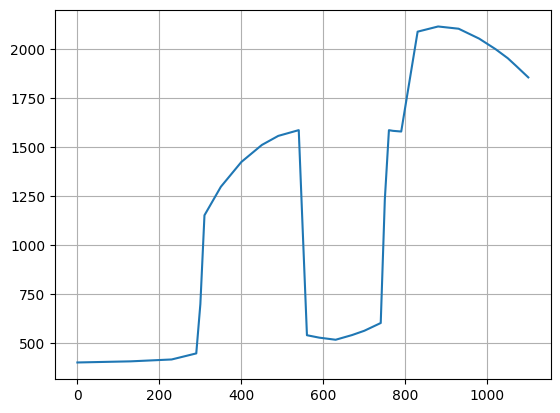

In [105]:
# Restructuring

Tfi_res=np.zeros(len(H)) # max T of the fuel after restructuring
Rcol=np.zeros(len(H)) # columnar grain radius after restructuring
Rfi_res=np.zeros(len(H)) # void/inner fuel radius after restructuring

for i in range(len(H)):
    Potenza=Ppeak*Pf[i]*1000

    if H[i]<=300 or (H[i]>=600 and H[i]<=800):
        if Tfinew[i]>1600: # 1600°C is the temperature at which restructuring take place, if T is lower restructuring cannot happen
            def Rcol_solver(Rx):
                return (1600 - Tfonew[i]) - (1-(Rx/Rfonew[i])**2)*Potenza/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((1600+Tfonew[i])/2))+ 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((1600+Tfonew[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((1600+Tfonew[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((1600+Tfonew[i])/2)*5.8*10**(-4)) ) ) )
            Rcol[i]=fsolve(Rcol_solver,1)

            if Rcol[i]>Rfonew[i]: # this IF set a maximum to Rcol
                Rcol[i]=Rfonew[i]

            Rfi_res[i]=math.sqrt(por*Rcol[i]**2) # see formula lecture 12/10: from mass balance equation

            def Tfi_res_solver(Tx):
                por_fin=0
                return ((Tx - 1600)*Rfonew[i]**2/(Potenza*(Rcol[i+1]**2 - Rfi_res[i]**2))) - (1 - math.log(Rcol[i]/Rfi_res[i]) * ( 2*(Rfi_res[i])**2/(Rcol[i]**2 - Rfi_res[i]**2) ))*1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+1600)/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+1600)/2)*10**(-4)) ) * ( (1 - por_fin*(2.58-((Tx+1600)/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+1600)/2)*5.8*10**(-4)) ) ) )
                #return ((Tx - Tfonew[i+1])/Potenza) - (1-(math.log(Rfonew[i+1]/Rfi_res[i+1])**2)/((Rfonew[i+1]/Rfi_res[i+1])**2 -1))*1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfonew[i+1])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfonew[i+1])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfonew[i+1])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfonew[i+1])/2)*5.8*10**(-4)) ) ) )

            sol=fsolve(Tfi_res_solver,1000)
            Tfi_res[i]=sol[0]
        else:
            Tfi_res[i]=Tfinew[i]

    else:
        if Tfinew[i]>1600:
            def Rcol_solver(Rx):
                return (1600 - Tfonew[i]) - (1-(Rx/Rfonew[i])**2)*Potenza*(1/(4*math.pi*(( 76.4*10**(-12)*((1600+Tfonew[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((1600+Tfonew[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
                #return (1600 - Tfonew[i+1]) - (1-(Rx/Rfonew[i])**2)*Potenza*(1-(math.log(Rfonew[i]/Rfinew[i])**2)/((Rfonew[i]/Rfinew[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tfinew[i+1]+Tfonew[i+1]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tfinew[i+1]+Tfonew[i+1]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))

            sol=fsolve(Rcol_solver,1)
            Rcol[i]=sol[0]

            if Rcol[i]>Rfonew[i]:
                Rcol[i]=Rfonew[i]

            Rfi_res[i]=math.sqrt((1-por)*Rfinew[i]**2 + por*Rcol[i]**2) # different from before because there is already void: derived from mass balance equation


            def Tfi_res_solver(Tx):
                por_fin=0
                return ((Tx - 1600)*Rfonew[i]**2/(Potenza*(Rcol[i]**2 - Rfi_res[i]**2))) - (1 - math.log(Rcol[i]/Rfi_res[i]) * ( 2*(Rfi_res[i])**2/(Rcol[i]**2 - Rfi_res[i]**2) ))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+1600+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+1600+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por_fin)/(1+2*por_fin))))
                #return ((Tx - Tfonew[i+1])/Potenza) - (1-(math.log(Rfonew[i+1]/Rfi_res[i+1])**2)/((Rfonew[i+1]/Rfi_res[i+1])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfonew[i+1]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfonew[i+1]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))

            sol=fsolve(Tfi_res_solver,1000)
            Tfi_res[i]=sol[0]
        else:
            Tfi_res[i]=Tfinew[i]
            Rfi_res[i]=Rfinew[i]



print("Colloidal Radius:\n"+str(Rcol))
print("\n\nNew Void/Inner Fuel Radius:\n"+str(Rfi_res))
print("\n\nNew Tfi:\n"+str(Tfi_res))
print("\n\nDifference before/after restructuring in T:\n"+str(Tfinew-Tfi_res))
plt.plot(H, Tfi_res)
plt.grid()

# Hot Geometry after restructuring


C:\Users\User\AppData\Local\Temp\ipykernel_20624\844210211.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tfon[i]=fsolve(Tfosolver,1000)


-264.3095839102789


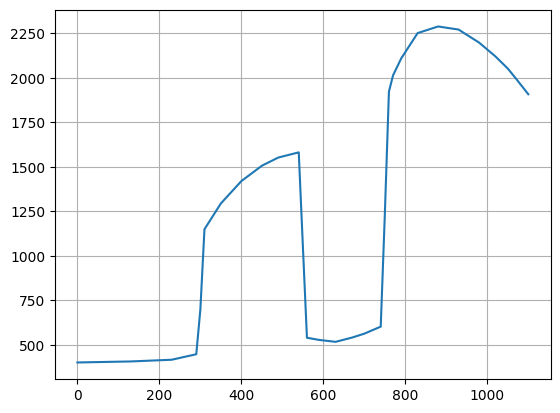

In [106]:
Tfin=Tfi_res
Tfio=Tfinew

Tfon=Tfonew
Tfoo=Tfonew
alpha=1.2*10**-5 #°C**-1

dev=0.05
BUFIMA=0
por=0.05

print(max(Tfin) - max(Tfio))
while abs(max(Tfin) - max(Tfio)) > 1:

    i=0

    while i<30:
        Tfio[i]=Tfin[i]
        Tfoo[i]=Tfon[i]
        i=i+1



    for i in range(len(Tfio)):
        Rfonew[i]=Rfo*(1+alpha*(-25+(Tfio[i]+Tfoo[i])/2))
        Rfinew[i]=Rfi_res[i]*(1+alpha*(-25+(Tfio[i]+Tfoo[i])/2))

    diff=Rcinew-Rfonew
    flag=0

    for i in range(len(diff)):
      if diff[i]<=0:
        flag=1
        print("Contact fuel cladding: end of cycle")
        break


    Tfon=np.zeros(len(H))

    for i in range(len(H)):

        q=Pf[i]*Ppeak*1000

        def Tfosolver(Tx):
            return ((Tx - Tcinew[i])/q) - (Rconew[i]-TCnew[i]-Rfonew[i])/(2*math.pi*Rcinew[i]*(15.8*(10**(-4))*((273.15 + ((Tfoo[i] + Tciold[i])/2))**(0.79))))

        Tfon[i]=fsolve(Tfosolver,1000)


    Tfin=np.zeros(len(H))

    for i in range(len(H)):
        Potenza=Ppeak*Pf[i]*1000
        if (H[i]<=300 or (H[i]>=600 and H[i]<=800)) and Rfi_res[i]==0:
            def Tfisolver(Tx):
                return ((Tx - Tfon[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tfio[i]+Tfoo[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tfio[i]+Tfoo[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tfio[i]+Tfoo[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tfio[i]+Tfoo[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfin[i]=sol[0]
        elif H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfon[i])/Potenza) - (1-(math.log((Rfonew[i]/Rfinew[i])**2))/((Rfonew[i]/Rfinew[i])**2 -1))/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tfio[i]+Tfoo[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tfio[i]+Tfoo[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tfio[i]+Tfoo[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tfio[i]+Tfoo[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfin[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfon[i])/Potenza) - (1-(math.log((Rfonew[i]/Rfinew[i])**2))/((Rfonew[i]/Rfinew[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tfio[i]+Tfoo[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tfio[i]+Tfoo[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
            sol=fsolve(Tfisolver,1000)
            Tfin[i]=sol[0]
plt.plot(H, Tfin)
plt.grid()

# Fuel longitudinal expansion

In [107]:
variation=0
z=np.zeros(len(H))
for i in range(len(H)-1):
    Tav=(Tfin[i]+Tfon[i]+Tfin[i+1]+Tfon[i+1])/4
    z[i+1]=(H[i+1]-H[i])*(1+alpha*Tav)+z[i]


print('The thermal expansion leads to an elongation of the fuel of: %.2fmm for a total length of %.2fmm' %(z[-1]-H[-1], z[-1]))

l_hole=0
l_nohole=0
for i in range(len(H)):
    Tav=(Tfin[i]+Tfon[i])/2
    if i==0:
        l_nohole=l_nohole+(H[1]-H[0])*(1+alpha*Tav)/2
    elif i==29:
        l_hole=l_hole+(H[29]-H[28])*(1+alpha*Tav)/2
    elif Rfinew[i]==0:
        l_nohole=l_nohole+(H[i+1]-H[i-1])*(1+alpha*Tav)/2
    else:
        l_hole=l_hole+(H[i+1]-H[i-1])*(1+alpha*Tav)/2

print(l_hole,l_nohole, l_hole+l_nohole)

The thermal expansion leads to an elongation of the fuel of: 11.85mm for a total length of 1111.85mm
659.3630584227461 452.4890455491968 1111.852103971943


# Burnup Analysis

In [108]:
maxBurnup=sp.symbols('maxBurnup')

media=0
for i in range(len(H)):
    media=media+maxBurnup*Pf[i]

media=media/len(H)
Bmax=sp.solve(sp.Eq(media, TargetB), maxBurnup)
print(Bmax)


def BurnupFIMA(BurnupArray):
    Burnup_v=np.copy(BurnupArray)
    for i in range(len(z)):
        if H[i]<=300 or (H[i]>=600 and H[i]<=800):
            ##UO2
            #Burnup as FIMA
            Ef=200 #MeV
            U5=239 #amu
            U8=238 #amu
            O=16 #amu
            x=0.007
            OM=2
            Nav=6.022*10**23
            #FIMA=((Bu)*(3MMUO2))/((Nav)*(0.7%)*(Wf))
            Burnup_v[i]=Burnup_v[i]*(0.7/3)/9.5 #%%

        else:
            ##MOX
            #Burnup as FIMA
            Ef=200 #MeV
            Pu=239 #amu
            U=238 #amu
            O=16 #amu
            x=0.23
            OM=2
            Nav=6.022*10**23
            #print((10**9*24*3600/1000)*(Pu+(1-x)*U/x+OM*O/x)*1.66*10**-27/(Ef*10**6*1.602*10**-19))
            Burnup_v[i]=Burnup_v[i]*(23.7/3)/9.5#%%

    return Burnup_v


Burnup=np.zeros(len(H))
for i in range(len(H)):
    Burnup[i]=Pf[i]*Bmax[0]

FIMA=BurnupFIMA(Burnup)
display(Burnup,FIMA)

[287.519522930570]


array([  0.28751952,   1.43759761,   2.87519523,   8.62558569,
        58.9415022 , 109.25741871, 129.38378532, 146.63495669,
       158.13573761, 163.88612807, 166.7613233 ,  90.56864972,
        14.37597615,  11.50078092,  11.50078092,  14.37597615,
        17.25117138,  23.00156183, 132.25898055, 241.51639926,
       255.89237541, 270.26835155, 281.76913247, 287.51952293,
       281.76913247, 264.5179611 , 247.26678972, 232.89081357,
       221.39003266, 204.13886128])

array([7.06188302e-03, 3.53094151e-02, 7.06188302e-02, 2.11856491e-01,
       1.44768602e+00, 9.08561692e+01, 1.07592832e+02, 1.21938543e+02,
       1.31502350e+02, 1.36284254e+02, 1.38675206e+02, 7.53149824e+01,
       1.19547591e+01, 9.56380729e+00, 2.82475321e-01, 3.53094151e-01,
       4.23712981e-01, 5.64950642e-01, 3.24846619e+00, 5.93198174e+00,
       6.28507589e+00, 6.63817004e+00, 2.34313279e+02, 2.39095182e+02,
       2.34313279e+02, 2.19967568e+02, 2.05621857e+02, 1.93667098e+02,
       1.84103290e+02, 1.69757579e+02])

# Cladding volumetric swelling

In [109]:
Volnew=0
for i in range(len(H)-1): #Thermal swelling
    section=math.pi*(Rconew[i+1]**2-Rcinew[i+1]**2)
    Volnew=Volnew+(H[i+1]-H[i])*section

Volold=H[-1]*math.pi*(Rco**2-Rci**2)
print("The thermal cladding volumetric swelling percentage is around %.2f%% " %((Volnew-Volold)*100/Volold))

def Radiation_swelling(T, phi,t):
    return 1.5*10**-3*math.exp(-2.5*((T-450)/100)**2)*(phi*t/10**22)**2.75

Volnew2=Volnew*(1+0.01*Radiation_swelling((max(Tcinew)+max(Tconew)+min(Tconew)+min(Tcinew))/4, fluxf, 360*24*3600))
Volnew3=Volnew2*(1+0.01*Radiation_swelling((max(Tcinew)+max(Tconew)+min(Tconew)+min(Tcinew))/4, 0.975*fluxf, 360*24*3600))
Volnew4=Volnew3*(1+0.01*Radiation_swelling((max(Tcinew)+max(Tconew)+min(Tconew)+min(Tcinew))/4, 0.950*fluxf, 360*24*3600))
Volnew5=Volnew4*(1+0.01*Radiation_swelling((max(Tcinew)+max(Tconew)+min(Tconew)+min(Tcinew))/4, 0.925*fluxf, 360*24*3600))
print("The irradiation cladding volumetric swelling percentage is around %.2f%% " %((Volnew5-Volnew)*100/Volnew))
print("The overall cladding volumetric swelling percentage is around %.2f%% " %((Volnew5-Volold)*100/Volold))

The thermal cladding volumetric swelling percentage is around 1.55% 
The irradiation cladding volumetric swelling percentage is around 0.68% 
The overall cladding volumetric swelling percentage is around 2.24% 


Cladding geometry after irradiation swelling

In [110]:
Rco_final=np.copy(Rconew)*(1+0.0109/3)
Rci_final=np.copy(Rcinew)*(1+0.0109/3)

# Fuel swelling

Raggi interni ed esterni finali

In [111]:
Rfo_val=np.copy(Rfonew)

for i in range(len(H)):
    Rfo_val[i]=Rfo_val[i]*(1+(0.07*Burnup[i]/100)/3)
display(Rci_final-Rfo_val)
print("C'è contatto :(")

Rfi_val=np.copy(Rfinew)
for i in range(len(H)):
    Rfi_val[i]=Rfi_val[i]*(1+(0.07*Burnup[i]/100)/3) #Raggio interno finale
display(Rfi_val)



array([ 0.09348919,  0.09217925,  0.09060149,  0.0840934 ,  0.02614592,
       -0.03640012, -0.06027319, -0.08061551, -0.09405935, -0.10069183,
       -0.10385263, -0.01323183,  0.0778661 ,  0.08146995,  0.08221515,
        0.07916208,  0.07605164,  0.06969984, -0.05756977, -0.18543681,
       -0.20211744, -0.21874909, -0.2333013 , -0.23934184, -0.2324119 ,
       -0.21247336, -0.19255572, -0.1759349 , -0.1626344 , -0.14262675])

C'è contatto :(


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.2812773 , 1.28965576, 1.29688971, 1.3017919 , 1.30432965,
       1.30578317, 1.27467994, 1.24333965, 1.24234774, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.51029903,
       0.5579612 , 0.5995408 , 1.5414465 , 1.54972961, 1.54706371,
       1.53275849, 1.51649196, 1.50142139, 1.48809369, 1.46593519])

In [112]:
e=(1+(0.07*Burnup[i]/100))/(1+(0.07*Burnup[i]/100)/3)
H_final=z[-1]*e
print(H_final)
print(0.07*Burnup[i]/100)

1212.9566234234524
0.14289720289649308


Giorno di contatto di ogni pellet

In [113]:
days=np.linspace(0,1440, 1441)
Rfo_val2=np.zeros(len(H))
Rfonew_copia=np.copy(Rfonew)
Rci_val2=np.zeros(len(H))
Rcinew_copia=np.copy(Rcinew)
T_contact=np.zeros(len(H))

for i in range(len(H)):
    for t in range(len(days)):
        Rfo_val2[i]=Rfonew_copia[i]*(1+(0.07*(Burnup[i]*days[t]/1440)/100)/3)
        Rci_val2[i]=Rcinew_copia[i]*(1+(0.01*Radiation_swelling(0.5*(Tcinew[i]+Tconew[i]), fluxf, days[t]*24*3600)/3))
        if Rci_val2[i]-Rfo_val2[i]<=0:

            T_contact[i]=days[t]
            break

display(T_contact)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 545.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 247., 220., 196.,
       174., 169., 178., 203., 232., 259., 284., 326.])

# Fission Gas Release

0.10665268588081676
0.011850298431201861


Text(0, 0.5, 'Upper Plenum Height (mm)')

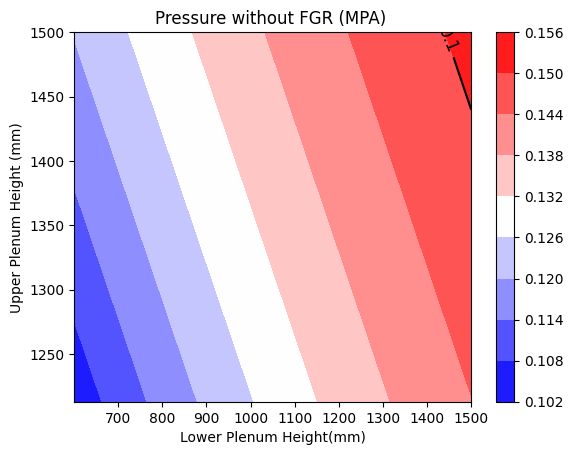

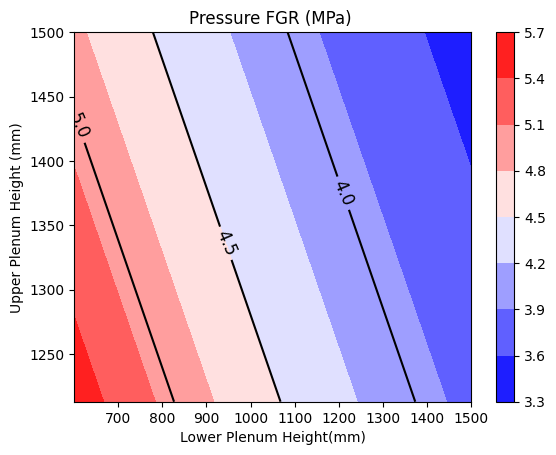

In [114]:
H_upper_plenum=np.linspace(int(H_final)+1, 1500, 1500-int(H_final))
H_lower_plenum=np.linspace(601, 1500, 900)

def V_upper(altezza, initial):
    assert altezza>0
    assert altezza>H_final

    if initial==True:
        return math.pi*altezza*Rci**2
    else:
        Vol=0
        for i in range(len(z)-1):
            Vol=Vol+(z[i+1]-z[i])*math.pi*Rci_final[i+1]**2

        Vol=Vol+math.pi*(altezza-z[-1])*Rci_final[-1]**2
        return Vol

def V_lower(altezza, initial):

    if initial==True:
        return altezza*math.pi*Rci**2
    else:
        return altezza*math.pi*Rci_final[0]**2

#V iniziale
def V_initial(H_upper, H_lower):
    assert H_lower>0
    assert H_upper>0

    return V_upper(H_upper, initial=True)+V_lower(H_lower, initial=True)-math.pi*(Rfo**2-Rfi**2)*(1-por)*600-math.pi*(Rfo**2)*500*(1-por)


#V finale
def V_final(H_upper, H_lower):
    assert H_lower>0
    assert H_upper>0

    Vfuel=0
    for i in range(len(H)-1):
        Vfuel=Vfuel+(z[i+1]-z[i])*math.pi*((Rfonew[i]**-Rfinew[i]**2)-por*(Rfonew[i]**2-Rcol[i]**2))

    return V_upper(H_upper, initial=False)+V_lower(H_lower, initial=False) -Vfuel*((1+0.07*Burnup[i]/100))


Vin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vin[i][j]=V_initial(H_upper_plenum[i],H_lower_plenum[j])

Vfin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vfin[i][j]=V_final(H_upper_plenum[i],H_lower_plenum[j])


# Plenum should be designed such that the final gas pressure is greater than the one of the coolant but below the deisgn limit (5MPa, see HW)
Pgas=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))

for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        nHe=(Pingas*(10**6) * Vin[i][j]*10**(-9))/(8.3145*(Tgas+273))
        Pgas[i][j]=(nHe*8.3145*(400+273))/(Vfin[i][j]*10**(-9))*10**-6 # MPa

levels=[0.15, 0.30,0.45,0.6]
plt.figure()
contour = plt.contour( H_lower_plenum,H_upper_plenum, Pgas, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  Pgas, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure without FGR (MPA) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")


# now let's consider fission gas release
FGR=0.9
YrateXe=0.27 # Xe atom released per fission event
YrateKr=0.03 # Kr atom released per fission event
EperFission=200 # MeV per fission

DenUO2=11 # g/cm3
DenPuO2= 11.5 # g/cm3

Vfuelfiss=math.pi*(Rfo**2-fiRfi**2)*600
Vfuelfert=math.pi*(Rfo**2)*500

FuelMass=(Vfuelfiss*(10**(-3))*(DenUO2*0.77 + DenPuO2*0.23) + Vfuelfert*(10**(-3))*(DenUO2))*10**-3 #kg

Etot=TargetB*(10**9 * 24*60*60)*(FuelMass*10**(-3)) # total energy generated in the whole life of the fuel pin

#print(Etot) # makes sense?

aFissionEvents=Etot/(EperFission*(10**6) * 1.6*10**(-19)) # all fission events inside a fuel pin

#print(aFissionEvents)

Na=6.022*10**(23) # Avogadro Number

nXe=YrateXe*aFissionEvents/Na
nKr=YrateKr*aFissionEvents/Na

print(nXe)
print(nKr)
n=nHe+FGR*(nXe+nKr)

PgasFGR=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))

for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        PgasFGR[i][j]=Pgas[i][j] +FGR*(nKr*8.3145*(400+273))/(Vfin[i][j]*10**(-3)) + FGR*(nXe*8.3145*(400+273))/(Vfin[i][j]*10**(-3))# MPa



levels = [4.0,4.5,5.0,6.0]

plt.figure()
contour = plt.contour( H_lower_plenum,H_upper_plenum, PgasFGR, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  PgasFGR, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure FGR (MPa) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")




In [115]:
print(PgasFGR[1250-int(H_final+1)][825-600])
print(H_upper_plenum[1250-int(H_final+1)])
print(H_lower_plenum[825-600])
print(H_upper_plenum[1250-int(H_final+1)]+H_lower_plenum[825-600])

4.916835410107079
1250.0
826.0
2076.0


# Thermal analysis of fuel-cladding contact

C:\Users\User\AppData\Local\Temp\ipykernel_20624\867589620.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
C:\Users\User\AppData\Local\Temp\ipykernel_20624\867589620.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo

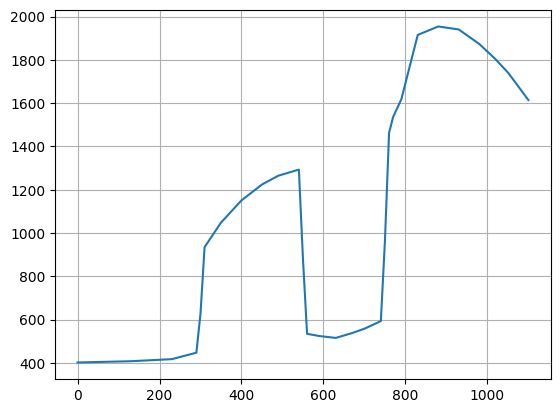

In [116]:
#Tfuelin
BUFIMA=0
Tfo_contact=np.copy(Tfonew)
Tfi_contact=np.copy(Tfinew)
for i in range(len(H)):
    Potenza=0.9*Ppeak*Pf[i]*1000
    if Rci_final[i]-Rfo_val[i]<=0:
        Tfo_contact[i]=Tcinew[i]
        if (H[i]<=300 or (H[i]>=600 and H[i]<=800)) and Rfi_res[i]==0:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        elif H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rci_final[i]/Rfi_val[i])**2))/((Rci_final[i]/Rfi_val[i])**2 -1))/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rci_final[i]/Rfi_val[i])**2))/((Rci_final[i]/Rfi_val[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfo_contact[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfo_contact[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
    else:
        def Tfosolver(Tx):
            return ((Tx - Tcinew[i])/Potenza) - (Rci_final[i]-Rfo_val[i]+0.01)/(2*math.pi*Rci_final[i]*(15.8*(10**(-4))*((273.15 + ((Tx + Tcinew[i])/2))**(0.79))))
        sol=fsolve(Tfosolver,1000)
        Tfo_contact[i]=sol[0]

        if (H[i]<=300 or (H[i]>=600 and H[i]<=800)) and Rfi_res[i]==0:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        elif H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rfo_val[i]/Rfi_val[i])**2))/((Rfo_val[i]/Rfi_val[i])**2 -1))/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rfo_val[i]/Rfi_val[i])**2))/((Rfo_val[i]/Rfi_val[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfo_contact[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfo_contact[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]

plt.plot(H,Tfi_contact)
plt.grid()


In [117]:
for i in range(len(H)):
    if Rcinew[i]-Rfo_val[i]<=0:
        Rfo_val2[i]=Rfo*(1+alpha*((Tfo_contact[i]+Tfi_contact[i])/2-273.15))*(1+0.07*Burnup[i]/100)**(2/3)

display(Rci_final-Rfo_val2)

array([ 0.09348919,  0.09217925,  0.09060149,  0.0840934 ,  0.02614592,
       -0.12038494, -0.16203928, -0.19767308, -0.22135934, -0.23314664,
       -0.23893886, -0.08092779,  0.0778661 ,  0.08146995,  0.08221515,
        0.07916208,  0.07605164,  0.06969984, -0.16130791, -0.38302991,
       -0.41208866, -0.4411653 , -0.47069088, -0.48189965, -0.47001572,
       -0.43498008, -0.399907  , -0.37062297, -0.34716892, -0.31190798])

# Fuel Margin to melting

In [118]:
def Tm_fuel(Bu, P,x):
    return 2964.92+((3147-364.85*P-1014.15*x)-2964.92)*math.exp(-Bu/40.43)



Pu_in=0.30/3 #[Pu]
Pu_out=0.23/3


Tm_f=np.zeros((2, len(H)))
for i in range(len(H)):
    Tm_f[0][i]=Tm_fuel(0,Pu_in,0.03)
    Tm_f[1][i]=Tm_fuel(0,Pu_out,0)

margin=min([min(Tm_f[0][:]-Tfinew),min(Tm_f[1][:]-Tfonew)])

print(margin)

Tm_f_end=np.zeros((2, len(H)))
for i in range(len(H)):
    Tm_f_end[0][i]=Tm_fuel(TargetB,Pu_in,0.03)
    Tm_f_end[1][i]=Tm_fuel(TargetB,Pu_out,0)

margin_end=min([min(Tm_f[0][:]-Tfi_contact),min(Tm_f[1][:]-Tfo_contact)])
print(margin_end)

791.9002617886736
1125.483448024734


# Thermal creep condition

In [119]:
Tcreep=np.zeros(len(H))
Tm_cladding=1400
for i in range(len(H)):
    Tcreep[i]=(Tcinew[i]+273.15)/(Tm_cladding+273.15)
display(Tcreep)


array([0.40235787, 0.40275456, 0.40465461, 0.40765059, 0.41385669,
       0.42005446, 0.42466903, 0.43019864, 0.43580548, 0.44041446,
       0.44630632, 0.43907459, 0.43181191, 0.43533572, 0.44078305,
       0.44687646, 0.45171087, 0.45857034, 0.47205934, 0.4853982 ,
       0.48851451, 0.49322709, 0.50086931, 0.50952869, 0.51686615,
       0.52272708, 0.5267377 , 0.52934327, 0.53073521, 0.53256868])

# funzioni utili

In [120]:
R=1.986 #cal/mol K
E_av=2 #Mev
v_f=0.32
def v_cladding(T):
    return 	0.277+6*10**-5*T

def Young_c(T):#GPa, T in celsius
    return 202.7-81.67*10**-3*T

def Young_f(T,Por):#MPa, T in celsius
    return (22.43*10**4-31.19*T)*(1-2.6*Por)

def Rupture_strain_c(T): #%
    return 8+4.74*10**-3*(T-500)+6.2*10**-5*(T-500)*2

def Yield_stress_c(T):#MPa, Ti in °C
    if T<600:
        return 555.5-0.25*T
    elif T<1000:
        return 405.5-0.775*(T-600)
    else:
        return 345.5-0.25*T

def UTS_c(T):
    if T<600:
        return 700-0.3125*T
    elif T<1000:
        return 512.5-0.969*(T-600)
    else:
        return 437.5-0.3125*T

def Irr_creep_strain_rate_c(sigma_eq):
        return 3.2*10**-24*E_av*fluxf*sigma_eq
def Tcreep_strain_rate_c(T,sigma_eq): #T in °C
    return 2.3*10**14*math.e**(-84600/(R*(T+273.15)))*math.sinh(34.54*sigma_eq/(0.8075*R*(T+273.15)))


# Radial Temperature Profile

Cold Geometry

Text(0, 0.5, 'Temperature (°C)')

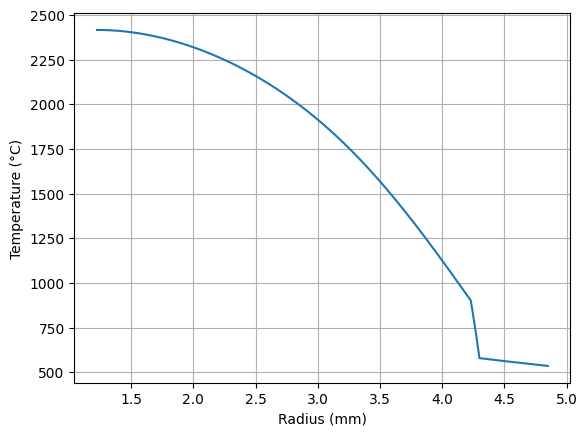

In [121]:
rvals1=np.linspace(Rco, Rci, int((Rco-Rci)*100))
rvals2=np.linspace(Rci, Rfo, int((Rci-Rfo)*100))
rvals3=np.linspace(Rfo,Rfi,int((Rfo-Rfi)*100))
dev=0.05
BUFIMA=0 #cold geometry
por=0.05


def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tco[23]], t_eval=rvals1)
T_c=sol1.y[0]

def dT_gapdr(r, T_gap):
    def K_gap(T_gap):
        return 15.8*10**-4*(T_gap+273.15)**0.79
    return -Ppeak*Pf[23]/(2*math.pi*r*K_gap(T_gap)/1000)

sol2=integrate.solve_ivp(dT_gapdr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)
T_g=sol2.y[0]

def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfi**2)/((Rfo**2-Rfi**2)*2*math.pi*r*K_fuel(T_fuel)/1000)

sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_g[-1]], t_eval=rvals3)
T_f=sol3.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3))
T_profile=np.concatenate((T_c,T_g,T_f))
plt.plot(rvals, T_profile)
plt.grid()
plt.xlabel("Radius (mm)")
plt.ylabel("Temperature (°C)")

In [122]:
print(max(T_profile))

2415.7378381286035


In [123]:
print(Rcinew[23])
print(Rfonew[23])

4.339392738402301
4.305644445968814


Hot geometry after restructuring

Text(0, 0.5, 'Temperature (°C)')

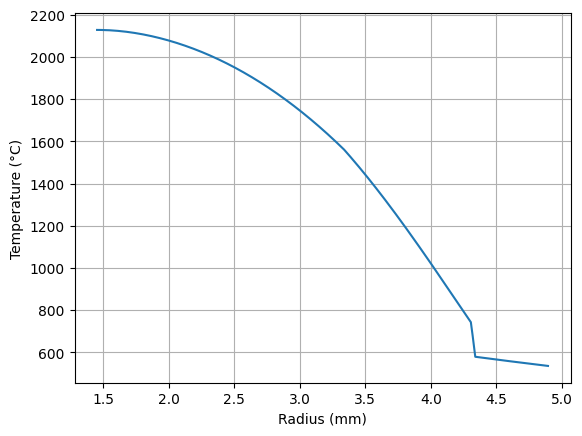

In [124]:
rvals1=np.linspace(Rconew[23], Rcinew[23], 60)
rvals2=np.linspace(Rcinew[23], Rfonew[23], 60)
rvals3=np.linspace(Rfonew[23],Rcol[23], 60)
rvals4=np.linspace(Rcol[23],Rfinew[23], 60)
dev=0.05
BUFIMA=0 #cold geometry
por=0.05

def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tconew[23]], t_eval=rvals1)
T_c=sol1.y[0]

def dT_gapdr(r, T_gap):
    def K_gap(T_gap):
        return 15.8*10**-4*(T_gap+273.15)**0.79
    return -Ppeak*Pf[23]/(2*math.pi*r*K_gap(T_gap)/1000)

sol2=integrate.solve_ivp(dT_gapdr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)
T_g=sol2.y[0]

def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfinew[23]**2)/((Rfonew[23]**2-Rfinew[23]**2)*2*math.pi*r*K_fuel(T_fuel)/1000)

sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_g[-1]], t_eval=rvals3)
T_f1=sol3.y[0]

dev=0.05
BUFIMA=0 #cold geometry
por=0
sol4=integrate.solve_ivp(dT_fueldr, (rvals4[0],rvals4[-1]), [T_f1[-1]], t_eval=rvals4)
T_f2=sol4.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3,rvals4))
T_profile=np.concatenate((T_c,T_g,T_f1,T_f2))

plt.plot(rvals, T_profile)
plt.grid()
plt.xlabel("Radius (mm)")
plt.ylabel("Temperature (°C)")


Cladding mechanical verification

C:\Users\User\AppData\Local\Temp\ipykernel_20624\1662859579.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma_cladding_rt[i]=M*(((rvals[i]**2-rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)-np.trapz(T_x_r[0:i+1], rvals[0:i+1]))
C:\Users\User\AppData\Local\Temp\ipykernel_20624\1662859579.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma_cladding_thetat[i]=M*(((rvals[i]**2+rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)+np.trapz(T_x_r[0:i+1], rvals[0:i+1])-T_x_r2[i])


array([-5.00000000e+00, -4.89899766e+00, -4.79864867e+00, -4.69894742e+00,
       -4.59988832e+00, -4.50146589e+00, -4.40367468e+00, -4.30650930e+00,
       -4.20996443e+00, -4.11403478e+00, -4.01871515e+00, -3.92400038e+00,
       -3.82988535e+00, -3.73636502e+00, -3.64343438e+00, -3.55108849e+00,
       -3.45932245e+00, -3.36813142e+00, -3.27751060e+00, -3.18745524e+00,
       -3.09796067e+00, -3.00902222e+00, -2.92063530e+00, -2.83279536e+00,
       -2.74549789e+00, -2.65873845e+00, -2.57251260e+00, -2.48681600e+00,
       -2.40164431e+00, -2.31699325e+00, -2.23285860e+00, -2.14923617e+00,
       -2.06612179e+00, -1.98351137e+00, -1.90140083e+00, -1.81978616e+00,
       -1.73866337e+00, -1.65802851e+00, -1.57787768e+00, -1.49820701e+00,
       -1.41901268e+00, -1.34029089e+00, -1.26203789e+00, -1.18424997e+00,
       -1.10692346e+00, -1.03005470e+00, -9.53640088e-01, -8.77676061e-01,
       -8.02159080e-01, -7.27085644e-01, -6.52452286e-01, -5.78255574e-01,
       -5.04492107e-01, -

array([41.74118231, 41.64017998, 41.53983099, 41.44012973, 41.34107064,
       41.24264821, 41.144857  , 41.04769162, 40.95114674, 40.8552171 ,
       40.75989747, 40.66518269, 40.57106767, 40.47754733, 40.38461669,
       40.2922708 , 40.20050476, 40.10931373, 40.01869291, 39.92863756,
       39.83914298, 39.75020453, 39.66181761, 39.57397767, 39.48668021,
       39.39992076, 39.31369492, 39.22799831, 39.14282662, 39.05817557,
       38.97404092, 38.89041848, 38.8073041 , 38.72469368, 38.64258315,
       38.56096848, 38.47984568, 38.39921082, 38.31905999, 38.23938933,
       38.16019499, 38.0814732 , 38.00322021, 37.92543229, 37.84810577,
       37.77123701, 37.6948224 , 37.61885838, 37.5433414 , 37.46826796,
       37.3936346 , 37.31943789, 37.24567442, 37.17234083, 37.09943379,
       37.02694999, 36.95488617, 36.88323908, 36.81200552, 36.74118231])

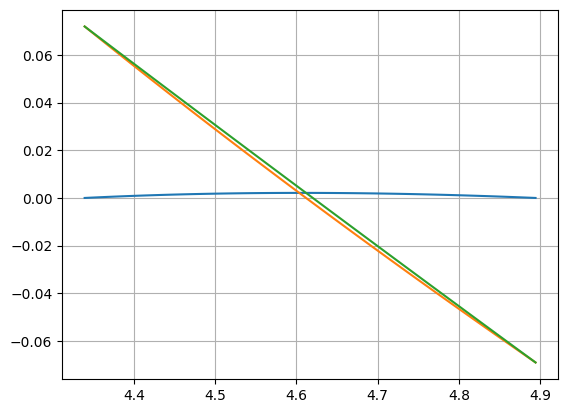

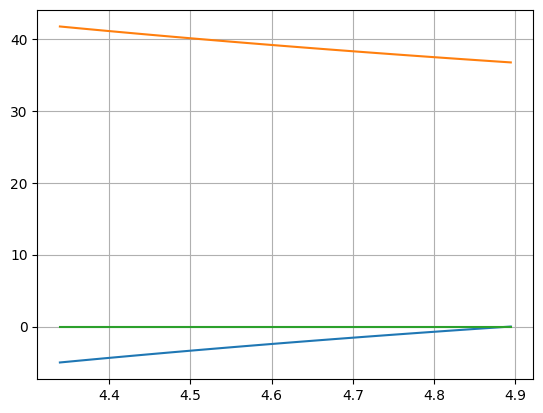

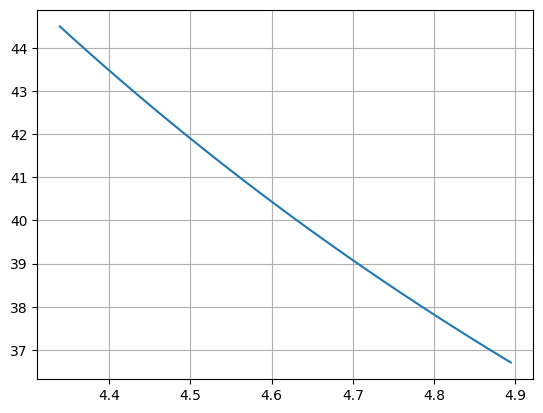

In [125]:
#Thermal

rvals=np.flip(np.copy(sol1.t))
Tvals=np.flip(np.copy(sol1.y[0]))

alpha_c=(-3.101*10**-4+1.545*10**-5*(Tvals)+2.75*10**-9*(Tvals)**2)/(Tvals-25)/100
sigma_cladding_rt=np.zeros(len(rvals))
sigma_cladding_thetat=np.zeros(len(rvals))
sigma_cladding_zt=np.zeros(len(rvals))

T_x_r=np.multiply(np.copy(Tvals),np.copy(rvals))
T_x_r2=np.multiply(np.copy(T_x_r),np.copy(rvals))

for i in range(len(rvals)):
    M=alpha_c[i]*Young_c(Tvals[i])*10**3/(1-v_c(Tvals[i]))/rvals[i]**2

    sigma_cladding_rt[i]=M*(((rvals[i]**2-rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)-np.trapz(T_x_r[0:i+1], rvals[0:i+1]))
    sigma_cladding_thetat[i]=M*(((rvals[i]**2+rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)+np.trapz(T_x_r[0:i+1], rvals[0:i+1])-T_x_r2[i])
    sigma_cladding_zt[i]=sigma_cladding_rt[i]+sigma_cladding_thetat[i]

plt.figure()
plt.plot(rvals, sigma_cladding_rt)
plt.plot(rvals, sigma_cladding_thetat)
plt.plot(rvals, sigma_cladding_zt)
plt.grid()

#Mechanical
a,b,r=sp.symbols("a b r")
sigma_r=a/r**2+b

sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-5) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])
display(sigma_cladding_rm,sigma_cladding_thetam)

plt.figure()
plt.plot(rvals, sigma_cladding_rm)
plt.plot(rvals, sigma_cladding_thetam)
plt.plot(rvals, sigma_cladding_zm)
plt.grid()

#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm+sigma_cladding_rt
sigma_cladding_theta=sigma_cladding_thetam+sigma_cladding_thetat
sigma_cladding_z=sigma_cladding_zm+sigma_cladding_zt
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.grid()

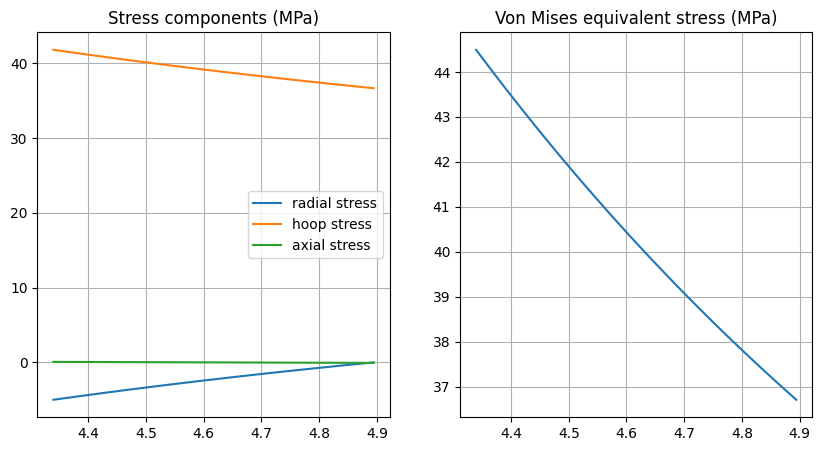

In [126]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(rvals, sigma_cladding_r, label="radial stress")
axs[0].plot(rvals, sigma_cladding_theta, label="hoop stress")
axs[0].plot(rvals, sigma_cladding_z, label="axial stress")
axs[0].set_title('Stress components (MPa)')
axs[0].legend()
axs[0].grid()
axs[1].plot(rvals, equivalent_stress)
axs[1].set_title('Von Mises equivalent stress (MPa)')
axs[1].grid()

In [127]:
print(Yield_stress_c(np.average(T_c)))

416.1678012341385


In [128]:
print((T_contact[23]))

169.0


Radial Profile with caldding fuel contact

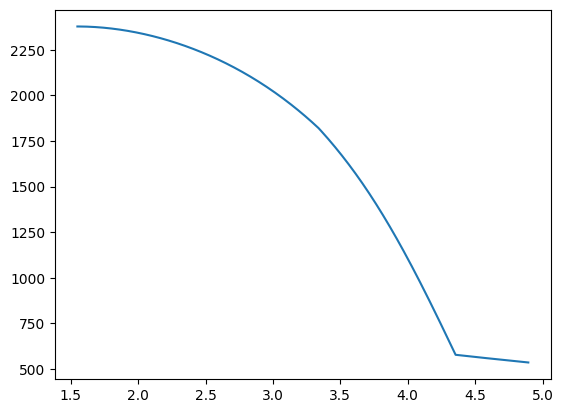

In [129]:
#work in progress
rvals1=np.linspace(Rconew[23], Rci_final[23], int((Rconew[23]-Rci_final[23])*100))
rvals2=np.linspace(Rci_final[23], Rcol[23], int((Rci_final[23]-Rcol[23])*100))
rvals3=np.linspace(Rcol[23],Rfi_val[23], int((Rcol[23]-Rfi_val[23])*100))
dev=0.05
BUFIMA=1
por=0.05

def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tconew[23]], t_eval=rvals1)
T_c=sol1.y[0]



def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfi_val[23]**2)/((Rcinew[23]**2-Rfi_val[23]**2)*2*math.pi*r*K_fuel(T_fuel)/1000)



sol2=integrate.solve_ivp(dT_fueldr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)

T_f1=sol2.y[0]

dev=0.05
por=0
sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_f1[-1]], t_eval=rvals3)
T_f2=sol3.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3))
T_profile=np.concatenate((T_c,T_f1,T_f2))
plt.plot(rvals, T_profile)

# PCI

Raggio interno al giorno di contatto per ogni pellet

In [130]:
Rfi_first_contact=np.zeros(len(H))
for i in range(len(H)):
    if T_contact[i]!=0:
        Rfi_first_contact[i]=Rfinew[i]*(1+(0.07*(Burnup[i]*T_contact[i]/1440)/100)/3)
display(Rfi_first_contact)

Rci_first_contact=np.zeros(len(H))
for i in range(len(H)):
    if T_contact[i]!=0:
        Rci_first_contact[i]=Rcinew[i]*(1+(0.011*T_contact[i]/1440)/3)
display(Rci_first_contact)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.27538654, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48774539,
       0.53132642, 0.56881595, 1.45784461, 1.46373269, 1.46342227,
       1.45621601, 1.44709724, 1.43795585, 1.42941423, 1.41437304])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       4.33776044, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.33916676,
       4.33919604, 4.3394728 , 4.34018433, 4.34126008, 4.34238633,
       4.34356166, 4.34453118, 4.34527066, 4.34580567, 4.34662333])

Contact pressure

0.00011696196412304164
-1.041067527091418e-05


np.float64(520.7967733203909)

410.9806420009669


array([-5.20796773e+02, -5.08927509e+02, -4.97142533e+02, -4.85441049e+02,
       -4.73822271e+02, -4.62285420e+02, -4.50829728e+02, -4.39454436e+02,
       -4.28158793e+02, -4.16942058e+02, -4.05803496e+02, -3.94742384e+02,
       -3.83758005e+02, -3.72849650e+02, -3.62016620e+02, -3.51258223e+02,
       -3.40573775e+02, -3.29962600e+02, -3.19424029e+02, -3.08957402e+02,
       -2.98562065e+02, -2.88237371e+02, -2.77982683e+02, -2.67797369e+02,
       -2.57680805e+02, -2.47632373e+02, -2.37651463e+02, -2.27737471e+02,
       -2.17889800e+02, -2.08107861e+02, -1.98391069e+02, -1.88738847e+02,
       -1.79150624e+02, -1.69625837e+02, -1.60163926e+02, -1.50764339e+02,
       -1.41426530e+02, -1.32149959e+02, -1.22934091e+02, -1.13778399e+02,
       -1.04682359e+02, -9.56454543e+01, -8.66671734e+01, -7.77470103e+01,
       -6.88844645e+01, -6.00790409e+01, -5.13302495e+01, -4.26376058e+01,
       -3.40006304e+01, -2.54188489e+01, -1.68917921e+01, -8.41899556e+00,
       -2.04636308e-12])

array([4481.5323857 , 4469.66312151, 4457.87814557, 4446.17666171,
       4434.55788309, 4423.02103215, 4411.56534042, 4400.19004844,
       4388.89440561, 4377.67767004, 4366.53910851, 4355.47799624,
       4344.49361688, 4333.58526232, 4322.75223259, 4311.99383577,
       4301.30938786, 4290.6982127 , 4280.15964181, 4269.69301433,
       4259.29767691, 4248.97298358, 4238.71829568, 4228.53298176,
       4218.41641747, 4208.36798545, 4198.38707528, 4188.47308334,
       4178.62541276, 4168.84347329, 4159.12668123, 4149.47445938,
       4139.88623688, 4130.36144918, 4120.89953793, 4111.49995094,
       4102.16214204, 4092.88557102, 4083.66970361, 4074.5140113 ,
       4065.41797135, 4056.38106668, 4047.4027858 , 4038.48262272,
       4029.62007693, 4020.81465328, 4012.06586191, 4003.37321823,
       3994.7362428 , 3986.1544613 , 3977.62740445, 3969.15460795,
       3960.73561238])

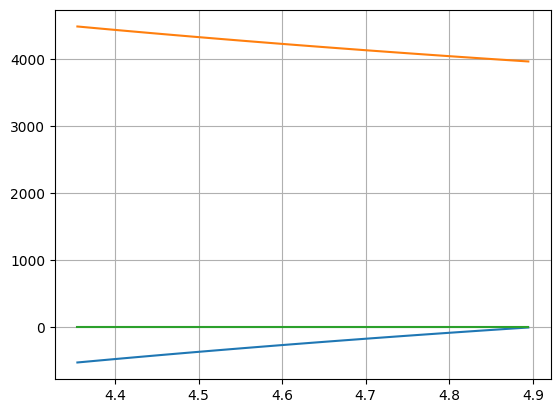

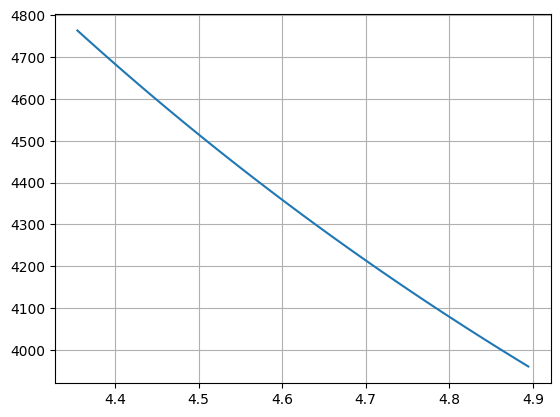

In [131]:
a=Rfi_val[23]
b=Rfo_val[23]
c=Rco_final[23]

i=(1/3)*Rfonew[23]*(0.07*(Burnup[23]*(1440-T_contact[23])/1440)/100)
print(((1000*Young_c(T_c[-1]))**-1*((b**2+c**2)/(c**2-b**2)+1/v_cladding(T_c[-1]))))
print((Young_f(T_c[-1], Por=0.05)**-1*((a**2+b**2)/(b**2-a**2)-1/v_f)))
p_contact=(i/b)/(((1000*Young_c(T_c[-1]))**-1*((b**2+c**2)/(c**2-b**2)+1/v_cladding(T_c[-1])))+(Young_f(T_c[-1], Por=0.05)**-1*((a**2+b**2)/(b**2-a**2)-1/v_f)))

display(p_contact)
print(Yield_stress_c(T_c[-1]))

rvals=np.flip(sol1.t)
a,b,r=sp.symbols("a b r")
sigma_r=a/r**2+b

sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-p_contact) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])
display(sigma_cladding_rm,sigma_cladding_thetam)

plt.figure()
plt.plot(rvals, sigma_cladding_rm)
plt.plot(rvals, sigma_cladding_thetam)
plt.plot(rvals, sigma_cladding_zm)
plt.grid()

#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm
sigma_cladding_theta=sigma_cladding_thetam
sigma_cladding_z=sigma_cladding_zm
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.grid()



Strain day

In [132]:
days=np.linspace(T_contact[23],1440, int(1440-T_contact[23])+1)

for t in range(len(days)):
    print(Rcinew[23])
    Rci_strain=Rcinew[23]*(1+(0.01*Radiation_swelling(np.average(T_c), fluxf, days[t]*24*3600)/3))
    if Rci_strain>=(1+0.002):
        T_strain=days[t]
        break

display(Rci_strain)
print(Yield_stress_c(T_c[-1]))
print(UTS_c(T_c[-1]))

4.339392738402301


np.float64(4.339430832743865)

410.9806420009669
519.3508025012086


Given $T_{des}$ and $\sigma_{des}$ verify $t_r$

In [133]:
SigmaEq=Yield_stress_c(T_c[-1])
strain=0.2
limit=Rupture_strain_c(np.average(T_c))

def final_strain(t):
    return float(strain+(Irr_creep_strain_rate_c(SigmaEq)+Tcreep_strain_rate_c(np.average(T_c),SigmaEq)+Radiation_swelling(np.average(T_c),fluxf, T_strain*24*3600)/((1440-T_strain)*24))*(t-T_strain)*24)-limit

t_r=fsolve(final_strain, 1440)[0]
print(t_r)

1476.3508987752311


C:\Users\User\AppData\Local\Temp\ipykernel_20624\19672414.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(strain+(Irr_creep_strain_rate_c(SigmaEq)+Tcreep_strain_rate_c(np.average(T_c),SigmaEq)+Radiation_swelling(np.average(T_c),fluxf, T_strain*24*3600)/((1440-T_strain)*24))*(t-T_strain)*24)-limit


Given $t_{des}$ and $\sigma_{des}$ verify $T_r$

In [134]:
def LMP_T(sigma, t):
    T=sp.symbols("T")
    LMP=(2060-sigma)/0.095
    T_rupture=sp.solve(sp.Eq(LMP, (T+273.15)*(17.125+math.log(t*24,10))))
    return T_rupture

print(LMP_T(SigmaEq, 1440-T_strain))
print(np.average(T_c))




[530.117708156209]
556.7035187774791


Given $T_{des}$ and $t_{des}$ verify $\sigma_r$

In [135]:
def LMP_sigma(T, t):
    sigma=sp.symbols("sigma")
    LMP=(T+273.15)*(17.125+math.log(t*24,10))
    sigma_rupture=sp.solve(sp.Eq(LMP, (2060-sigma)/0.095 ))
    return sigma_rupture

print(LMP_sigma(np.average(T_c), 1440-T_strain))

[356.402926604939]


In [136]:
T_des=np.average(T_c)+273.15
T_r=LMP_T(SigmaEq, 1440-T_strain)[0]+273.15

Sigma_des=SigmaEq
Sigma_r=LMP_sigma(np.average(T_c), 1440-T_strain)[0]

t_des=1440-T_strain
#t_r c'è già

Verification={"Temperature": T_r/T_des, "Stress": Sigma_r/Sigma_des, "Time-to-Rupture": t_r/t_des}
display(Verification)


{'Temperature': 0.967963248911163,
 'Stress': 0.867201250330668,
 'Time-to-Rupture': np.float64(1.1615664034423534)}